# TRAINING NOTEBOOK
## BARBADOS TRAFFIC ANALYSIS CHALLENGE

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import random
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from scipy import stats

from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree
import lightgbm as lgb

import warnings

warnings.filterwarnings('ignore')

In [ ]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.dates as mdates
# from datetime import datetime
# from sklearn import preprocessing
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
# from sklearn import metrics
# from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, confusion_matrix, classification_report, accuracy_score, f1_score
# from sklearn.feature_selection import SelectFromModel
# from xgboost import XGBClassifier
# from xgboost import plot_importance, plot_tree

In [2]:
def set_seed(seed=42):
  np.random.seed(seed)
  random.seed(seed)
  print(f"random seed set to {seed}")

set_seed(42)

random seed set to 42


# Exploring Dataset

In [3]:
TRAIN_CSV = 'Train.csv'
TEST_CSV = 'TestInputSegments.csv'
SUBMISSION_CSV = 'SampleSubmission.csv'
VIDEO_FEATURES_CSV = 'final_updated_dataset_features.csv'

train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)
submission = pd.read_csv(SUBMISSION_CSV)
video_features = pd.read_csv(VIDEO_FEATURES_CSV)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Submission shape: {submission.shape}")
print(f"video features shape: {video_features.shape}")

Train shape: (13218, 14)
Test shape: (2640, 14)
Submission shape: (880, 3)
video features shape: (3229, 35)


In [4]:
train.head()

,responseId,view_label,ID_enter,ID_exit,videos,video_time,datetimestamp_start,datetimestamp_end,date,signaling,congestion_enter_rating,congestion_exit_rating,time_segment_id,cycle_phase
0,zYkHaeOdB7XOnvgP3YW5kQs,Norman Niles #1,time_segment_0_Norman Niles #1_congestion_ente...,time_segment_0_Norman Niles #1_congestion_exit...,normanniles1/normanniles1_2025-10-20-06-00-45.mp4,2025-10-20 06:00:45,2025-10-20 06:00:45,2025-10-20 06:01:44,2025-10-20,none,free flowing,free flowing,0.0,train
1,NYsHaeCRLq-vnvgPjoXZqA0,Norman Niles #1,time_segment_1_Norman Niles #1_congestion_ente...,time_segment_1_Norman Niles #1_congestion_exit...,normanniles1/normanniles1_2025-10-20-06-01-45.mp4,2025-10-20 06:01:45,2025-10-20 06:01:45,2025-10-20 06:02:44,2025-10-20,none,free flowing,free flowing,1.0,train
2,A40HaYT8KNm7nvgPq8e12AU,Norman Niles #1,time_segment_2_Norman Niles #1_congestion_ente...,time_segment_2_Norman Niles #1_congestion_exit...,normanniles1/normanniles1_2025-10-20-06-02-45.mp4,2025-10-20 06:02:45,2025-10-20 06:02:45,2025-10-20 06:03:00,2025-10-20,none,free flowing,free flowing,2.0,train
3,EIsHaanDMK-vnvgPjoXZqA0,Norman Niles #1,time_segment_3_Norman Niles #1_congestion_ente...,time_segment_3_Norman Niles #1_congestion_exit...,normanniles1/normanniles1_2025-10-20-06-03-45.mp4,2025-10-20 06:03:45,2025-10-20 06:03:45,2025-10-20 06:04:44,2025-10-20,none,free flowing,free flowing,3.0,train
4,RYsHafSeMaqpmecP5vCV0AQ,Norman Niles #1,time_segment_4_Norman Niles #1_congestion_ente...,time_segment_4_Norman Niles #1_congestion_exit...,normanniles1/normanniles1_2025-10-20-06-04-45.mp4,2025-10-20 06:04:45,2025-10-20 06:04:45,2025-10-20 06:04:59,2025-10-20,none,free flowing,free flowing,4.0,train


In [5]:
extracted_names = train['videos'].str.split("/").str[-1]
filtered_train = train[extracted_names.isin(video_features['video_name'])]

print(f"Original 16k shape: {train.shape}")
print(f"Filtered shape: {filtered_train.shape}")

Original 16k shape: (13218, 14)
Filtered shape: (3229, 14)


In [6]:
filtered_train['congestion_enter_rating'].value_counts(normalize=True)

,proportion
congestion_enter_rating,
free flowing,0.474760
moderate delay,0.190461
light delay,0.171880
heavy delay,0.162899


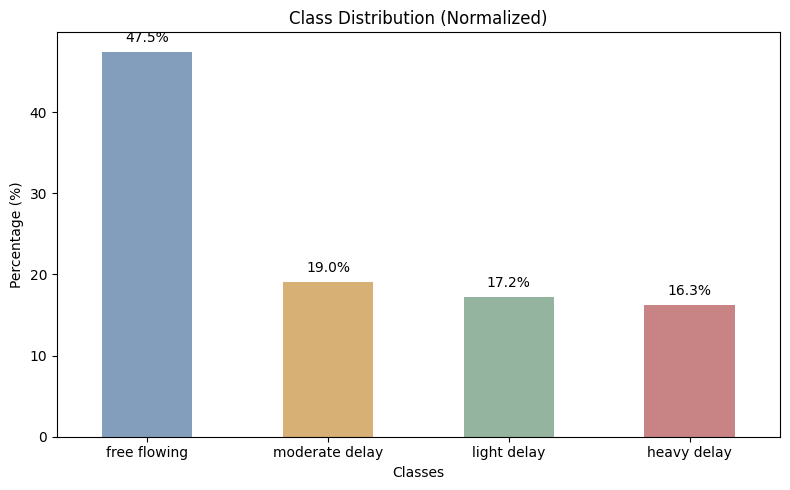

In [7]:
percentages = filtered_train['congestion_enter_rating'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
ax = percentages.plot(kind='bar', color=['#829EBC', '#D6B075', '#94B49F', '#C88484'])

plt.title('Class Distribution (Normalized)')
plt.ylabel('Percentage (%)')
plt.xlabel('Classes')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [8]:
# dataset = pd.read_csv(VIDEO_FEATURES_CSV)
# dataset.dtypes

In [9]:
# sns.countplot(x='congestion_enter_rating', data=dataset, palette='husl')
# plt.show()

In [10]:
# sns.countplot(x='congestion_exit_rating', data=dataset, palette='husl')
# plt.show()

- We can clearly see the class imbalance here.

In [8]:
video_features.groupby("congestion_enter_rating").mean(numeric_only=True)

,number_of_vehicles_entry,number_of_vehicles_exit,number_of vehicles_roundabout,avg_time_spent_entry,avg_time_spent_exit,avg_time_spent_from_roundabout,avg_idle_time_entry,avg_idle_time_exit,avg_idle_time_from_roundabout,idle_0_entry,...,time_spent_0_entry,time_spent_1_entry,time_spent_2_entry,time_spent_3_entry,time_spent_4_entry,time_spent_0_exit,time_spent_1_exit,time_spent_2_exit,time_spent_3_exit,time_spent_4_exit
congestion_enter_rating,,,,,,,,,,,,,,,,,,,,,
free flowing,26.425962,12.809524,12.021526,40.294047,11.471069,7.407229,12.315603,3.736538,0.041902,20.696673,...,13.741683,4.191129,3.553164,1.984997,2.954990,7.836269,4.838878,0.062622,0.027397,0.044357
heavy delay,44.452471,17.186312,18.492395,55.804401,8.609916,6.964819,19.209724,2.618423,0.041247,32.834601,...,21.699620,6.874525,5.290875,3.416350,7.171103,10.218631,6.596958,0.190114,0.110266,0.070342
light delay,35.266667,15.753153,16.488288,45.485238,10.710277,7.748172,14.789512,3.496811,0.083323,27.282883,...,19.028829,5.039640,4.257658,2.598198,4.342342,9.111712,6.400000,0.111712,0.050450,0.079279
moderate delay,39.582114,15.278049,18.294309,52.188387,9.410892,7.816617,17.666771,3.023266,0.072781,29.639024,...,21.058537,5.104065,4.552846,3.050407,5.816260,9.043902,6.003252,0.125203,0.043902,0.061789


In [9]:
new_dataset = video_features.copy()
MAPPING = {
    "free flowing": 0,
    "light delay": 1,
    "moderate delay": 2,
    "heavy delay": 3
}
SIGNAL_MAPPING = {
    'none': 0,
    'low': 1,
    'medium': 2,
    'high': 3
}

new_dataset["congestion_enter_rating"] = new_dataset["congestion_enter_rating"].map(MAPPING)
new_dataset["congestion_exit_rating"] = new_dataset["congestion_exit_rating"].map(MAPPING)
new_dataset["signaling"] = new_dataset["signaling"].map(SIGNAL_MAPPING)


In [ ]:
# new_dataset = dataset.copy()
# new_dataset['date_time'] = pd.to_datetime(new_dataset['date_time'])
# mapping = {
#     "free flowing": 0,
#     "light delay": 1,
#     "moderate delay": 2,
#     "heavy delay": 3
# }
# signal_mapping = {
#     'none': 0,
#     'low': 1,
#     'medium': 2,
#     'high': 3
# }
# new_dataset["congestion_enter_rating"] = new_dataset["congestion_enter_rating"].map(mapping)
# new_dataset["congestion_exit_rating"] = new_dataset["congestion_exit_rating"].map(mapping)
# new_dataset["signaling"] = new_dataset["signaling"].map(signal_mapping)

In [10]:
num_cols = [col for col in new_dataset.columns if new_dataset[col].dtype != object]
num_cols

['number_of_vehicles_entry',
 'number_of_vehicles_exit',
 'number_of vehicles_roundabout',
 'avg_time_spent_entry',
 'avg_time_spent_exit',
 'avg_time_spent_from_roundabout',
 'avg_idle_time_entry',
 'avg_idle_time_exit',
 'avg_idle_time_from_roundabout',
 'idle_0_entry',
 'idle_1_entry',
 'idle_2_entry',
 'idle_3_entry',
 'idle_4_entry',
 'idle_0_exit',
 'idle_1_exit',
 'idle_2_exit',
 'idle_3_exit',
 'idle_4_exit',
 'time_spent_0_entry',
 'time_spent_1_entry',
 'time_spent_2_entry',
 'time_spent_3_entry',
 'time_spent_4_entry',
 'time_spent_0_exit',
 'time_spent_1_exit',
 'time_spent_2_exit',
 'time_spent_3_exit',
 'time_spent_4_exit',
 'signaling',
 'congestion_enter_rating',
 'congestion_exit_rating']

In [ ]:
new_dataset[num_cols].corr()['congestion_enter_rating'].sort_values(ascending=False)

,congestion_enter_rating
congestion_enter_rating,1.000000
number_of_vehicles_entry,0.547112
idle_0_entry,0.498626
time_spent_4_entry,0.449048
time_spent_0_entry,0.378356
avg_idle_time_entry,0.375422
congestion_exit_rating,0.371852
idle_4_entry,0.353457
avg_time_spent_entry,0.351187
signaling,0.345759


In [ ]:
# new_dataset[num_cols].corr()['congestion_exit_rating'].sort_values(ascending=False)

,congestion_exit_rating
congestion_exit_rating,1.000000
congestion_enter_rating,0.371852
number_of_vehicles_entry,0.214371
idle_0_entry,0.196517
time_spent_4_entry,0.175774
time_spent_1_entry,0.136501
idle_4_entry,0.127303
idle_2_entry,0.116394
idle_1_entry,0.112408
time_spent_0_entry,0.112238


#

In [85]:
def create_time_features(df):
  df_time = df.copy()
  df_time['hour'] = df_time['date_time'].dt.hour
  df_time['minute'] = df_time['date_time'].dt.minute
  df_time['day_of_week'] = df_time['date_time'].dt.dayofweek

  df_time['hour_sin'] = np.sin(2 * np.pi * df_time['hour'] / 24)
  df_time['hour_cos'] = np.cos(2 * np.pi * df_time['hour'] / 24)

  df_time['is_rush_hour'] = df_time['hour'].apply(lambda x: 1 if x in [7,8,9,16,17,18] else 0)
  df_time['is_morning_rush'] = df_time['hour'].apply(lambda x: 1 if x in [7,8,9] else 0)
  df_time['is_evening_rush'] = df_time['hour'].apply(lambda x: 1 if x in [16,17,18] else 0)
  df_time['hour_bin'] = pd.cut(df_time['hour'],
                            bins=[0, 5, 9, 12, 15, 18, 21, 24],
                            labels=['night', 'early_morning', 'morning', 'midday', 'afternoon', 'evening', 'late_night'],
                            include_lowest=True)

  df_time['rolling_idle_0_10m'] = df_time['idle_0_entry'].rolling(window=10).mean().fillna(0)
  return df_time

def create_previous_features(df, cols, window=10):
  df_prev = df.copy()
  for col in cols:
    for i in range(1, window + 1):
      df_prev[f"{col}_t_m_{i}"] = df_prev.groupby('camera')[col].shift(i)

  return df_prev

def create_target_features(df, cols, window=5):
  df_target = df.copy()
  for col in cols:
    for i in range(1, window + 1):
      df_target[f"{col}_t_{i}"] = df_target.groupby('camera')[col].shift(-i)
  return df_target

# def filter_valid_rows(df):
#   df_filtered = df.copy()
#   for i in range(1, 6):
#     df_filtered[f'time_segment_id_t{i}'] = df_filtered.groupby('view_label')['time_segment_id'].shift(-i)

#   df_filtered = df_filtered.dropna()

#   filter_mask = (
#       (df_filtered['time_segment_id'] == df_filtered['time_segment_id_t1'] - 1) &
#       (df_filtered['time_segment_id'] == df_filtered['time_segment_id_t2'] - 2) &
#       (df_filtered['time_segment_id'] == df_filtered['time_segment_id_t3'] - 3) &
#       (df_filtered['time_segment_id'] == df_filtered['time_segment_id_t4'] - 4) &
#       (df_filtered['time_segment_id'] == df_filtered['time_segment_id_t5'] - 5)
#   )
#   # df_filtered = df_filtered[filter_mask]
#   # df_filtered = df_filtered[10:].reset_index(drop=True)
#   return filter_mask



In [86]:
# Time features
new_dataset['date_time'] = pd.to_datetime(new_dataset['date_time'])
new_dataset_time = create_time_features(new_dataset)

# filter_mask = filter_valid_rows(filtered_train)
# new_dataset_time = new_dataset_time[filter_mask]
# new_dataset_time = new_dataset_time[10:].reset_index(drop=True)
new_dataset_time.head()
# Previous time features
previous_features = [
    'congestion_enter_rating',
    'congestion_exit_rating',
    'signaling',
    'hour',
    'minute',
    'number_of_vehicles_entry',
    'number_of_vehicles_exit',
    'number_of vehicles_roundabout',
    'idle_0_entry',
    'idle_4_entry',
    'time_spent_0_entry',
    'time_spent_4_entry'
]

final_dataset = create_previous_features(new_dataset_time, previous_features, 10)

target_features = ['congestion_enter_rating', 'congestion_exit_rating']
final_dataset = create_target_features(final_dataset, target_features, 5)

print(f"train shape after the feature engineering : {final_dataset.shape}")

train shape after the feature engineering : (3229, 175)


In [87]:
final_dataset.columns

Index(['video_name', 'camera', 'date_time', 'number_of_vehicles_entry',
       'number_of_vehicles_exit', 'number_of vehicles_roundabout',
       'avg_time_spent_entry', 'avg_time_spent_exit',
       'avg_time_spent_from_roundabout', 'avg_idle_time_entry',
       ...
       'congestion_enter_rating_t_1', 'congestion_enter_rating_t_2',
       'congestion_enter_rating_t_3', 'congestion_enter_rating_t_4',
       'congestion_enter_rating_t_5', 'congestion_exit_rating_t_1',
       'congestion_exit_rating_t_2', 'congestion_exit_rating_t_3',
       'congestion_exit_rating_t_4', 'congestion_exit_rating_t_5'],
      dtype='object', length=175)

In [ ]:
# df = new_dataset.copy()
# lagged_features = ['congestion_enter_rating', 'congestion_exit_rating', 'signaling', 'number_of_vehicles_entry', 'number_of_vehicles_exit', 'number_of vehicles_roundabout', 'idle_0_entry', 'time_spent_0_entry', 'time_spent_4_entry']
# df = create_time_features(df)
# df = create_previous_features(df, lagged_features)
# df = create_target_features(df, ['congestion_enter_rating', 'congestion_exit_rating'])
# df.columns

Index(['video_name', 'camera', 'date_time', 'number_of_vehicles_entry',
       'number_of_vehicles_exit', 'number_of vehicles_roundabout',
       'avg_time_spent_entry', 'avg_time_spent_exit',
       'avg_time_spent_from_roundabout', 'avg_idle_time_entry',
       'avg_idle_time_exit', 'avg_idle_time_from_roundabout', 'idle_0_entry',
       'idle_1_entry', 'idle_2_entry', 'idle_3_entry', 'idle_4_entry',
       'idle_0_exit', 'idle_1_exit', 'idle_2_exit', 'idle_3_exit',
       'idle_4_exit', 'time_spent_0_entry', 'time_spent_1_entry',
       'time_spent_2_entry', 'time_spent_3_entry', 'time_spent_4_entry',
       'time_spent_0_exit', 'time_spent_1_exit', 'time_spent_2_exit',
       'time_spent_3_exit', 'time_spent_4_exit', 'signaling',
       'congestion_enter_rating', 'congestion_exit_rating', 'hour', 'minute',
       'hour_sin', 'hour_cos', 'congestion_enter_rating_t_m_1',
       'congestion_enter_rating_t_m_2', 'congestion_enter_rating_t_m_3',
       'congestion_enter_rating_t_m_4', '

In [ ]:
# len(df)

3229

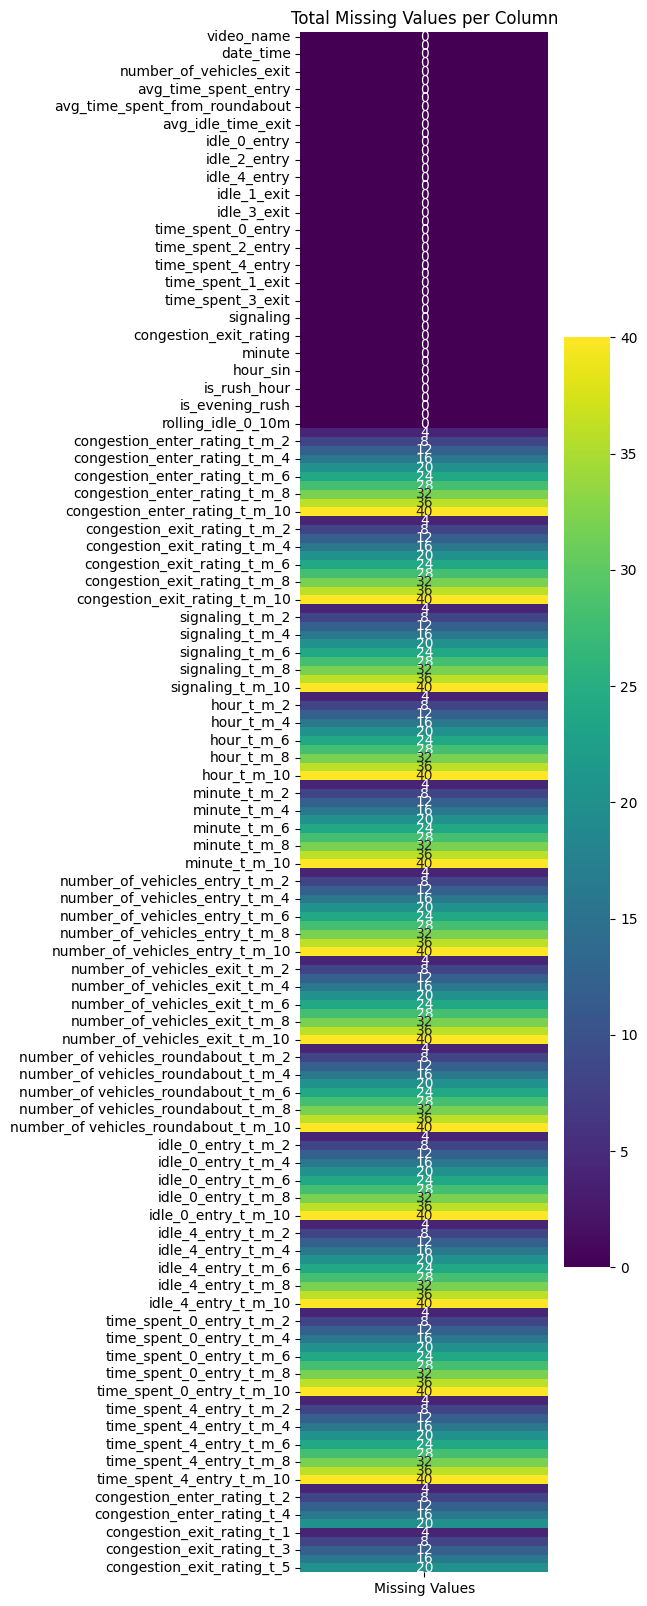

In [88]:
def plot_nan_value_counts(df):
  nan_counts = df.isna().sum().to_frame(name="Missing Values")

  plt.figure(figsize=(4, 20))
  sns.heatmap(nan_counts, annot=True, fmt="d", cmap="viridis", cbar=True)
  plt.title("Total Missing Values per Column")
  plt.show()

plot_nan_value_counts(final_dataset)

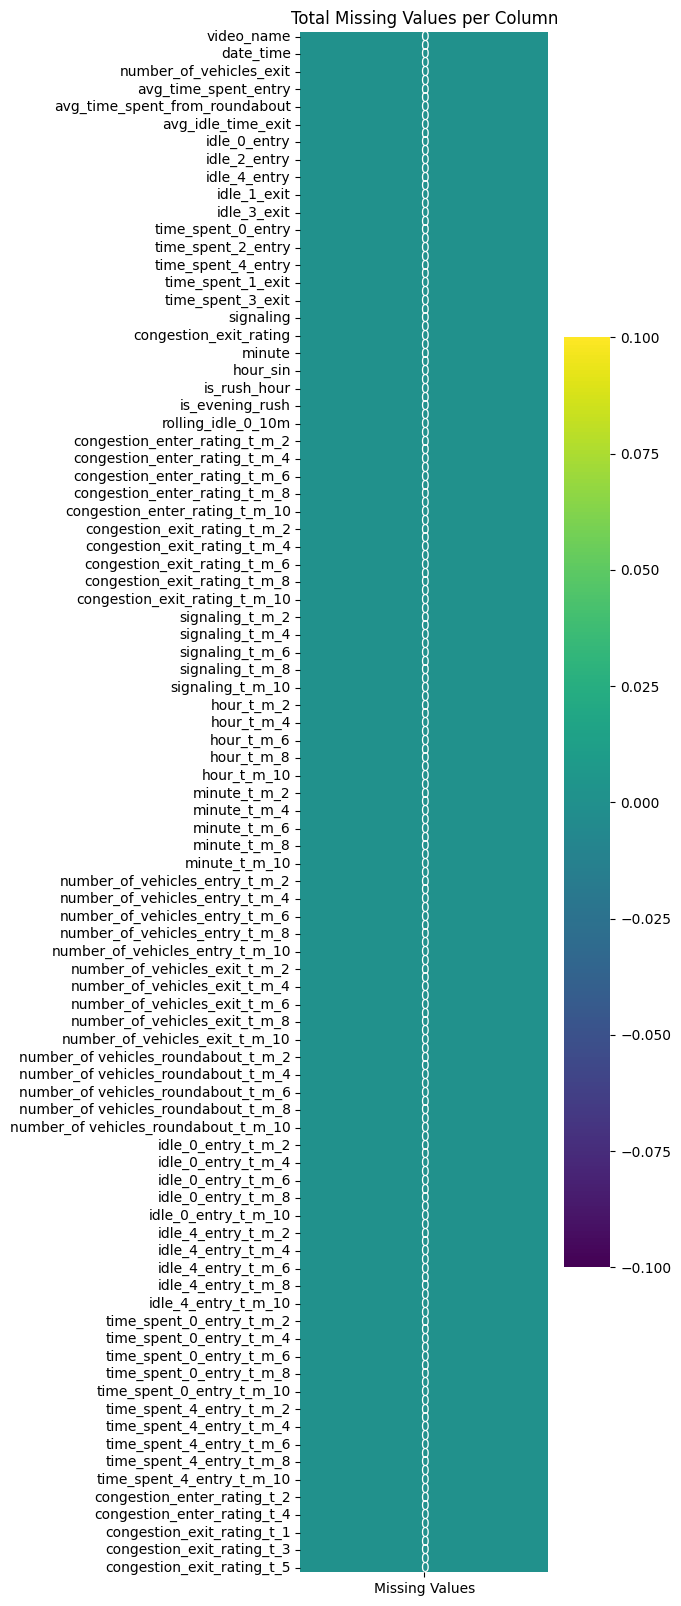

In [89]:
df_trimmed = final_dataset.groupby('camera', group_keys=False).apply(lambda x:x.iloc[10: -10])
plot_nan_value_counts(df_trimmed)

In [90]:
drop_cols = ['video_name', 'date_time']
df_final = df_trimmed.drop(drop_cols, axis=1)
df_final.columns

Index(['camera', 'number_of_vehicles_entry', 'number_of_vehicles_exit',
       'number_of vehicles_roundabout', 'avg_time_spent_entry',
       'avg_time_spent_exit', 'avg_time_spent_from_roundabout',
       'avg_idle_time_entry', 'avg_idle_time_exit',
       'avg_idle_time_from_roundabout',
       ...
       'congestion_enter_rating_t_1', 'congestion_enter_rating_t_2',
       'congestion_enter_rating_t_3', 'congestion_enter_rating_t_4',
       'congestion_enter_rating_t_5', 'congestion_exit_rating_t_1',
       'congestion_exit_rating_t_2', 'congestion_exit_rating_t_3',
       'congestion_exit_rating_t_4', 'congestion_exit_rating_t_5'],
      dtype='object', length=173)

In [91]:
categorical_features = [col for col in df_final.columns if df_final[col].dtype == object]
df_cat = pd.get_dummies(df_final[categorical_features], drop_first=True, dtype=int)
df_final = pd.concat([df_final.drop(categorical_features, axis=1), df_cat], axis=1)
df_final.columns

Index(['number_of_vehicles_entry', 'number_of_vehicles_exit',
       'number_of vehicles_roundabout', 'avg_time_spent_entry',
       'avg_time_spent_exit', 'avg_time_spent_from_roundabout',
       'avg_idle_time_entry', 'avg_idle_time_exit',
       'avg_idle_time_from_roundabout', 'idle_0_entry',
       ...
       'congestion_enter_rating_t_4', 'congestion_enter_rating_t_5',
       'congestion_exit_rating_t_1', 'congestion_exit_rating_t_2',
       'congestion_exit_rating_t_3', 'congestion_exit_rating_t_4',
       'congestion_exit_rating_t_5', 'camera_normanniles2',
       'camera_normanniles3', 'camera_normanniles4'],
      dtype='object', length=175)

# Downsampling

In [92]:
df_final['congestion_enter_rating'].value_counts()

,count
congestion_enter_rating,
0,1483
2,604
1,542
3,520


In [93]:
drop_index = df_final[
    ((df_final['congestion_enter_rating_t_1'] == 0) &
    (df_final['congestion_enter_rating_t_2'] == 0) &
    (df_final['congestion_enter_rating_t_3'] == 0) &
    (df_final['congestion_enter_rating_t_4'] == 0) &
    (df_final['congestion_enter_rating_t_5'] == 0))
    ].sample(frac=0.5, random_state=42).index

df_final = df_final.drop(drop_index).reset_index(drop=True)
print(f"train shape after downsampling : {df_final.shape}")

train shape after downsampling : (2965, 175)


In [94]:
df_final['congestion_enter_rating'].value_counts()

,count
congestion_enter_rating,
0,1322
2,598
1,526
3,519


In [95]:
target_enter_features = ['congestion_enter_rating_t_1', 'congestion_enter_rating_t_2', 'congestion_enter_rating_t_3', 'congestion_enter_rating_t_4', 'congestion_enter_rating_t_5']
target_exit_features = ['congestion_exit_rating_t_1', 'congestion_exit_rating_t_2', 'congestion_exit_rating_t_3', 'congestion_exit_rating_t_4', 'congestion_exit_rating_t_5']

X = df_final.drop(target_enter_features + target_exit_features, axis=1)
y_enter = df_final[target_enter_features]
y_exit = df_final[target_exit_features]

df_final.shape, X.shape, y_enter.shape, y_exit.shape

((2965, 175), (2965, 165), (2965, 5), (2965, 5))

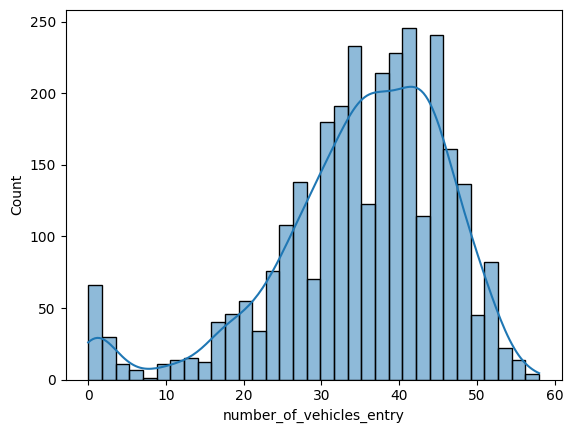

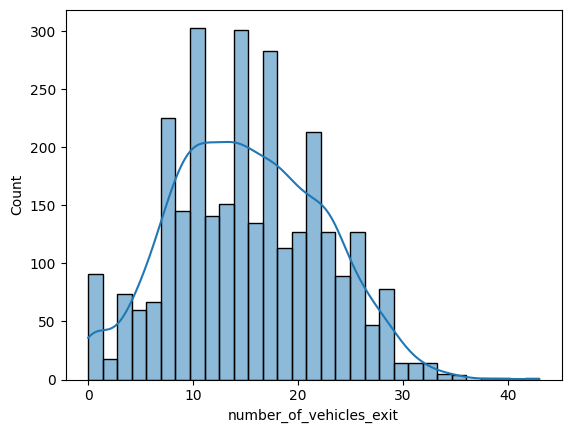

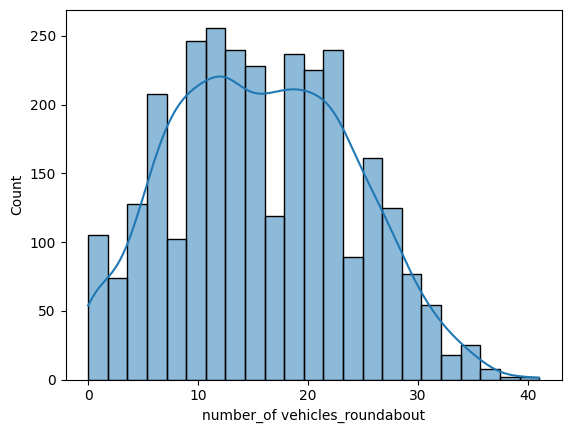

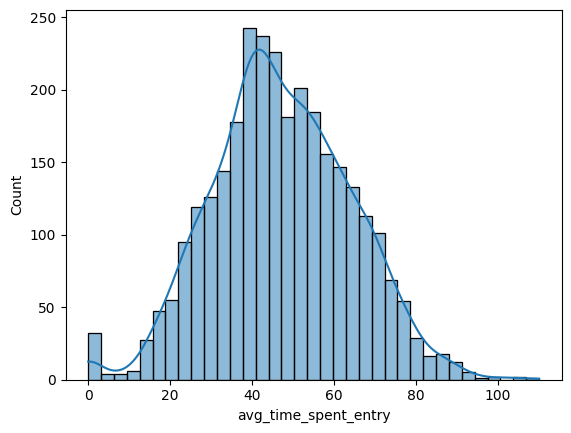

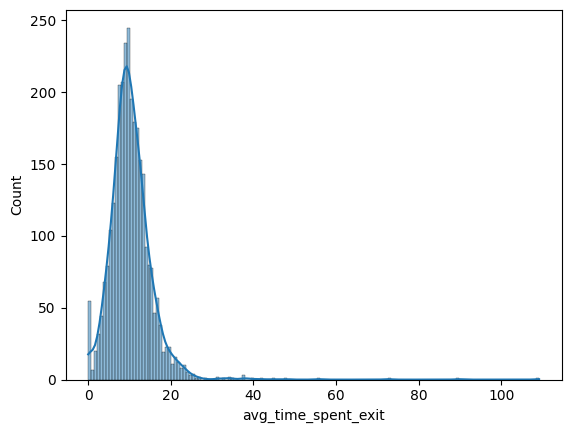

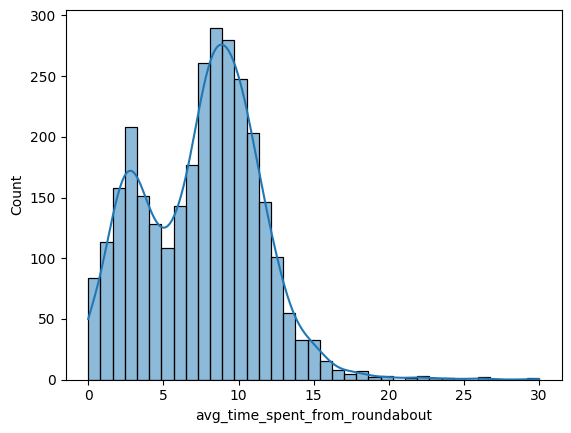

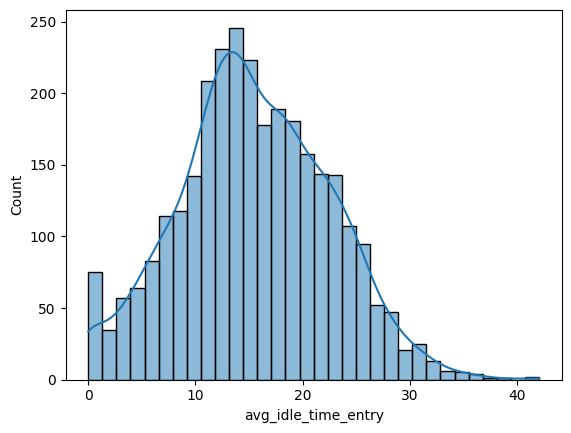

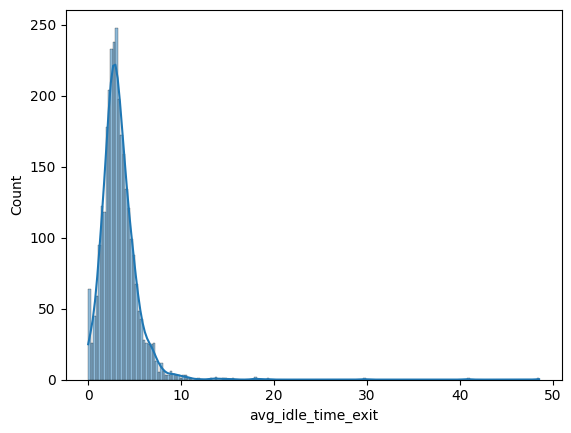

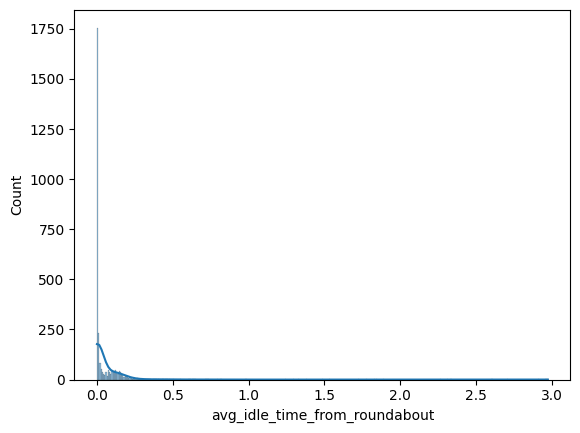

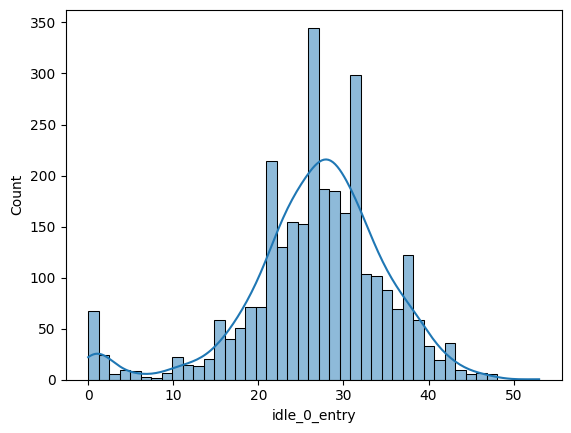

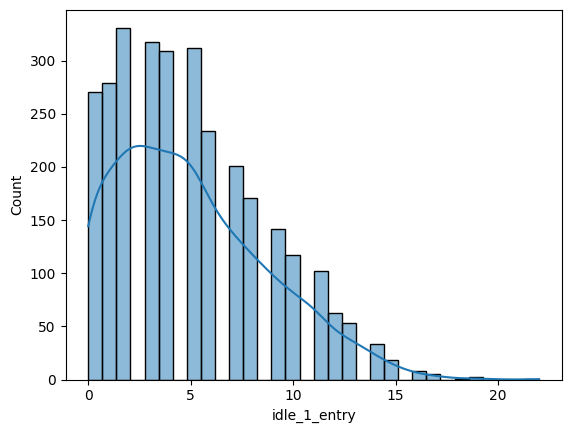

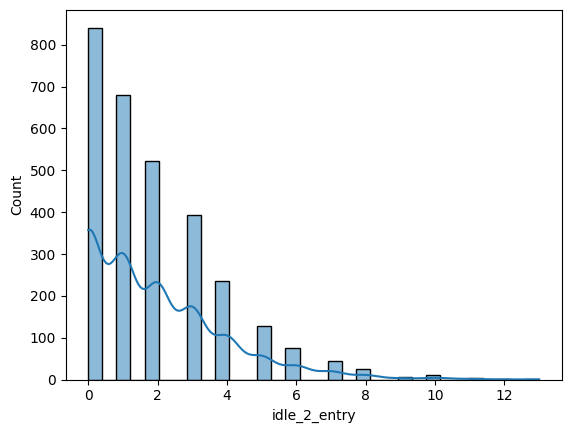

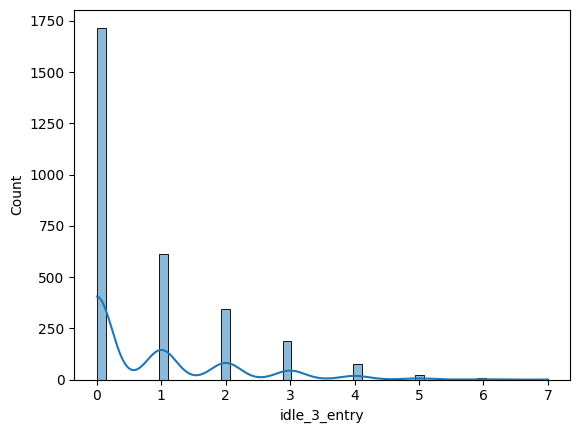

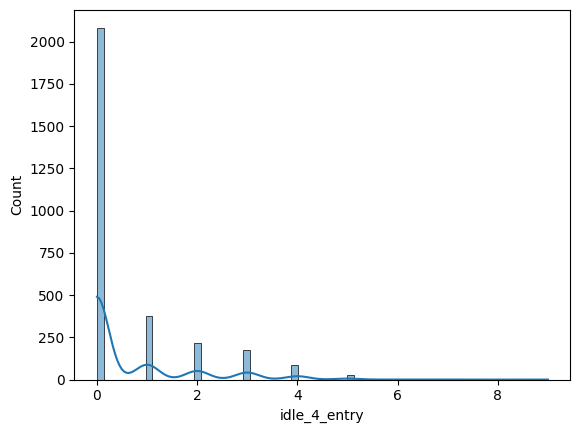

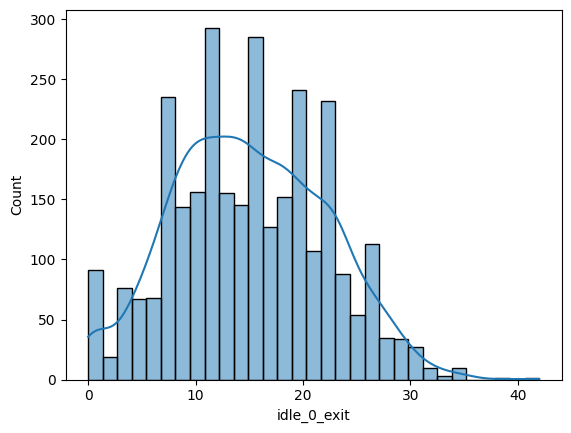

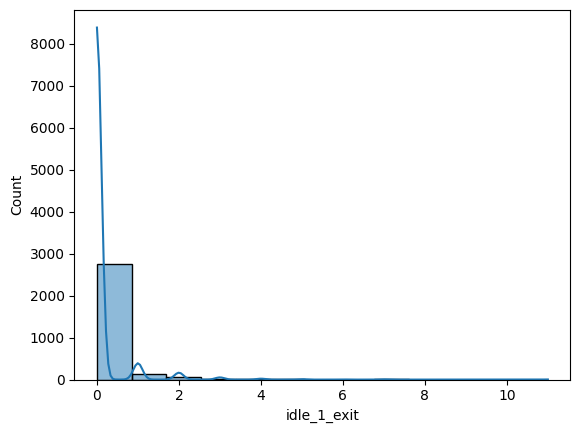

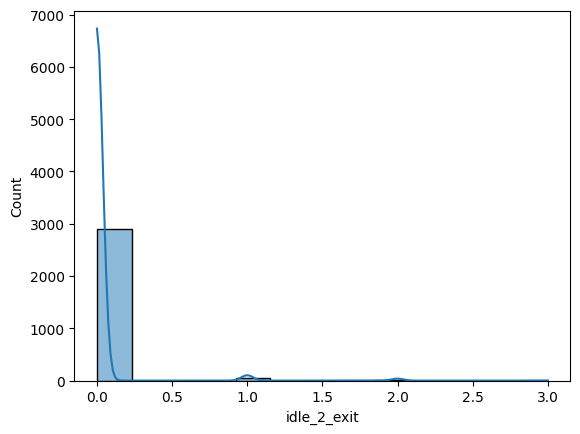

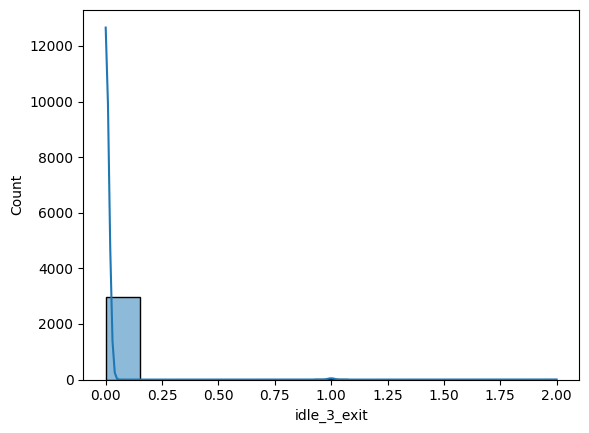

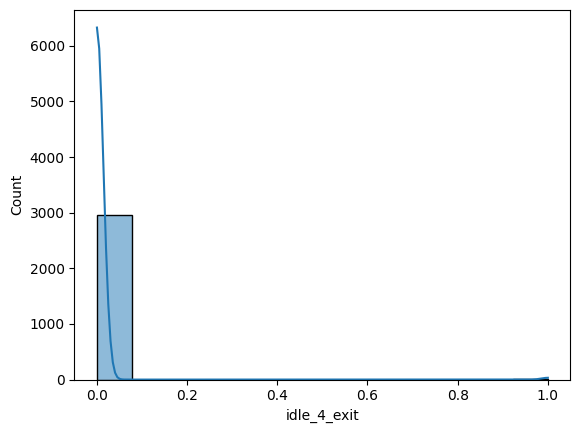

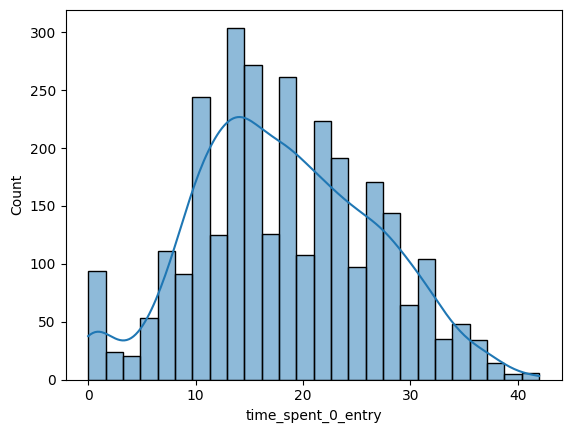

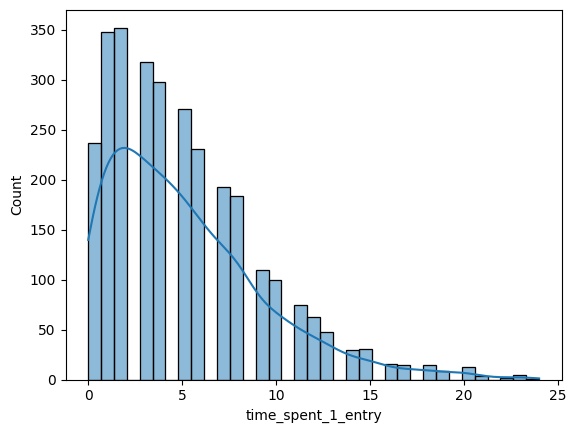

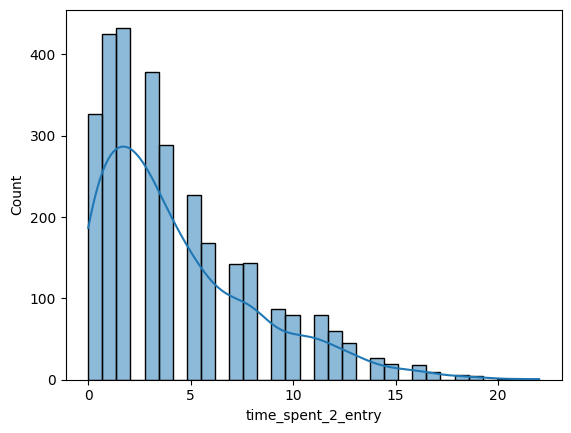

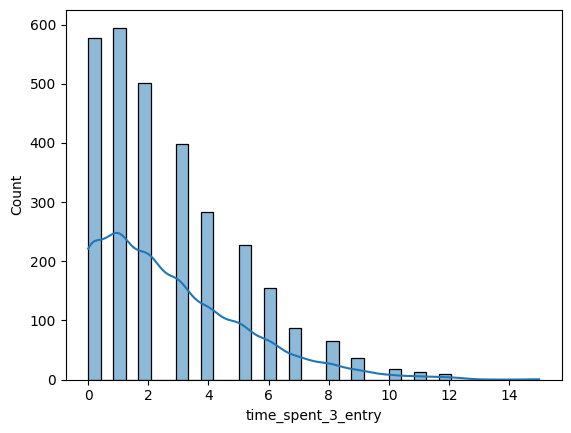

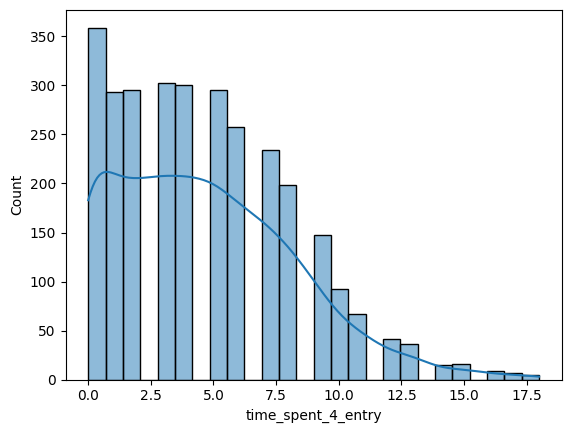

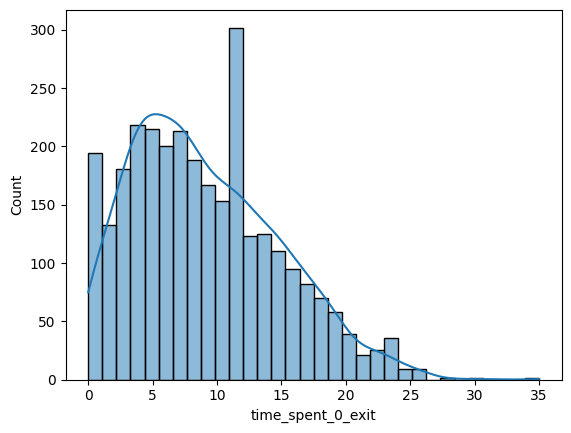

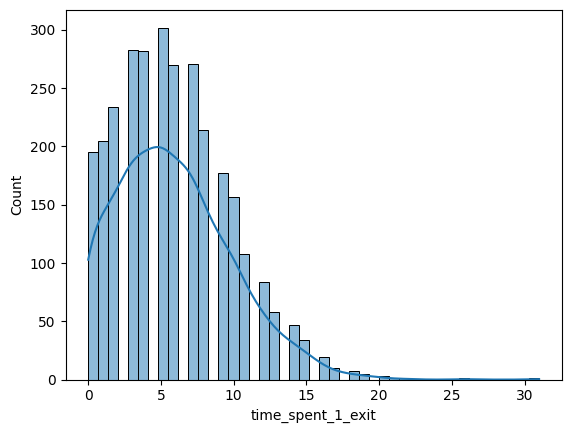

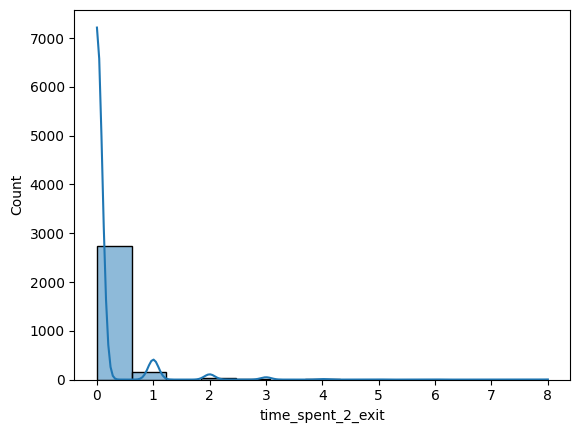

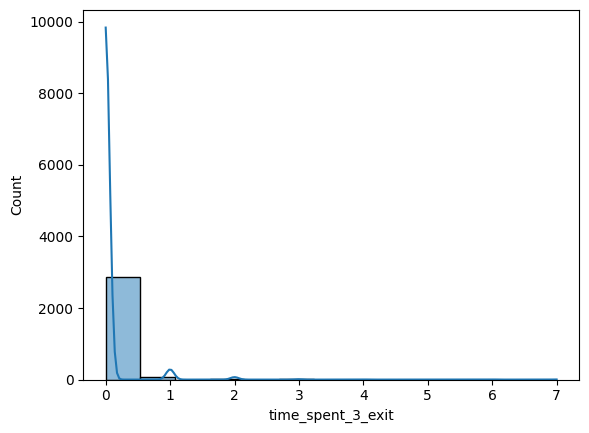

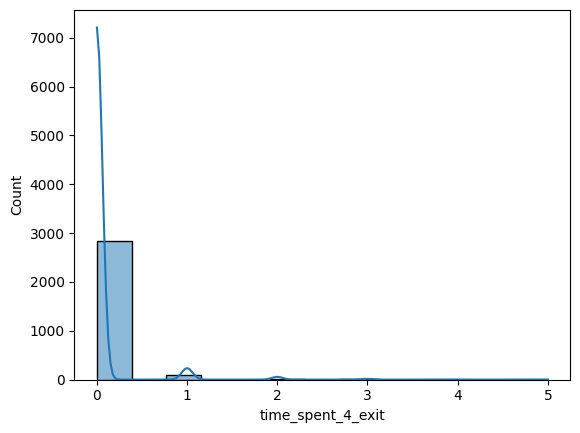

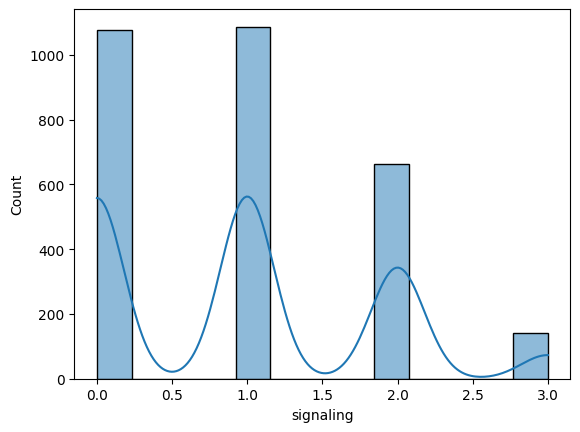

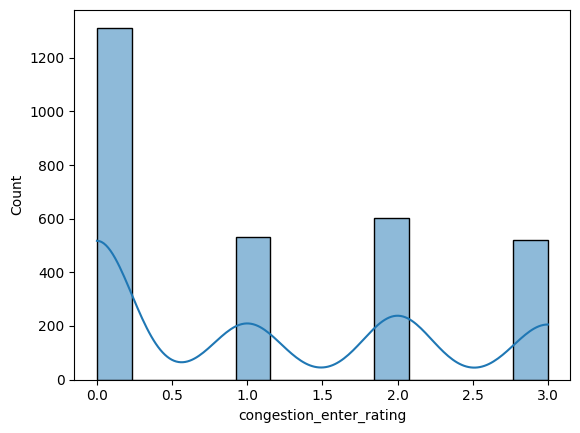

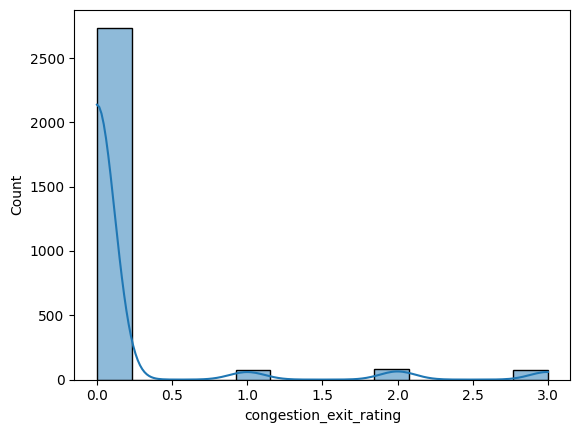

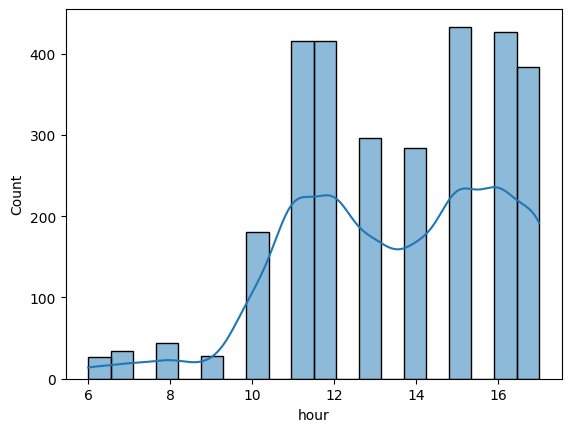

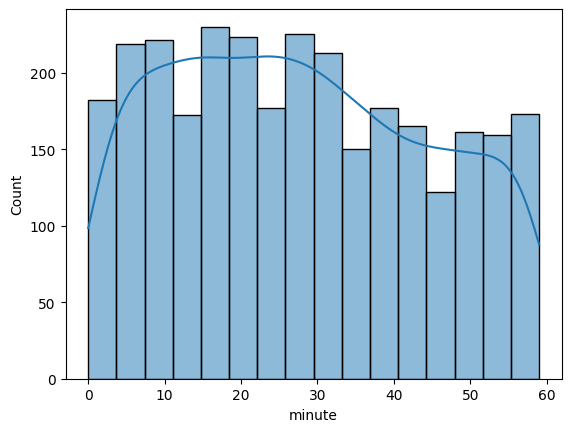

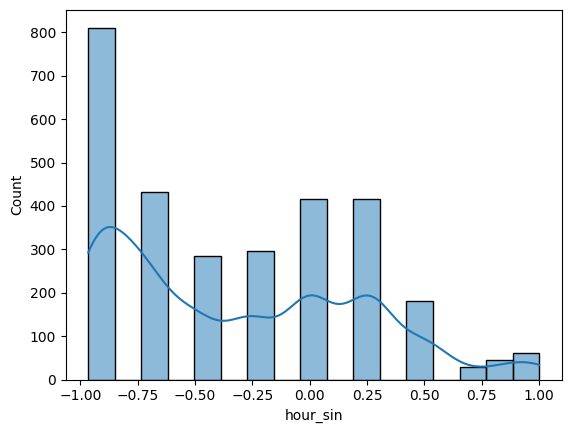

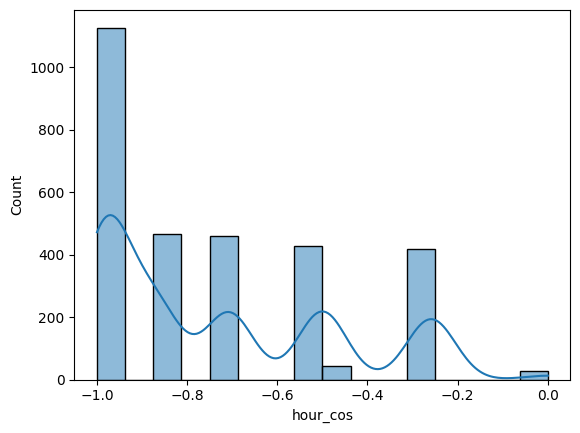

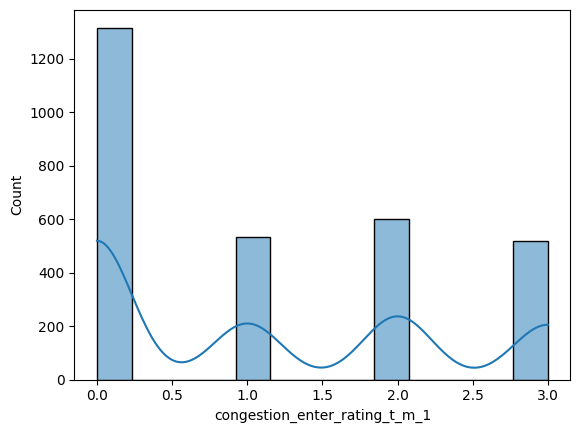

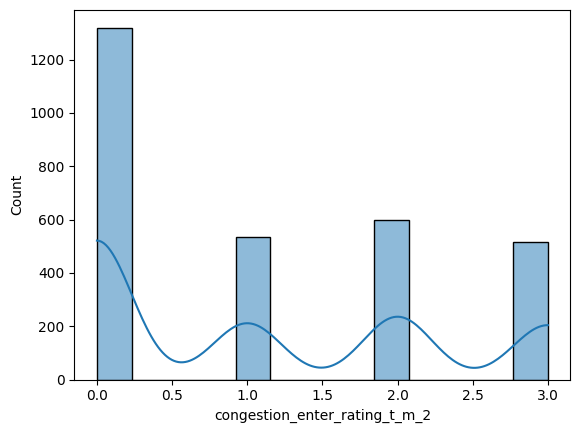

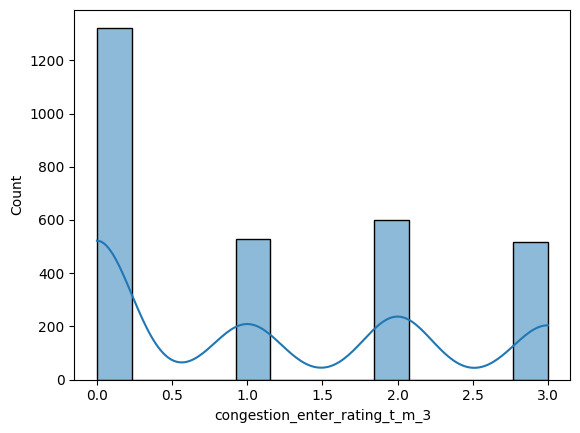

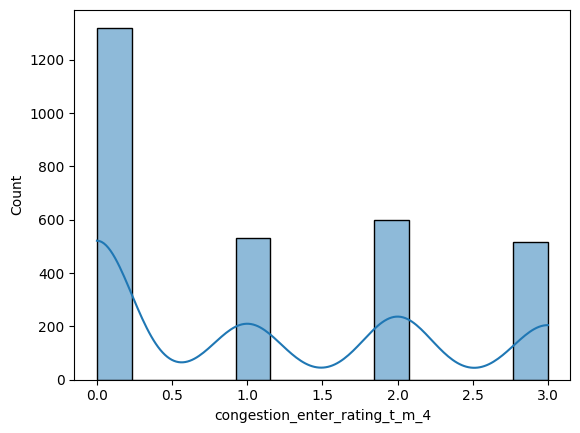

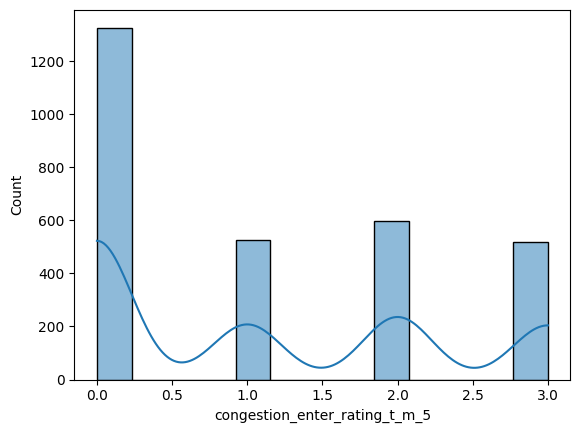

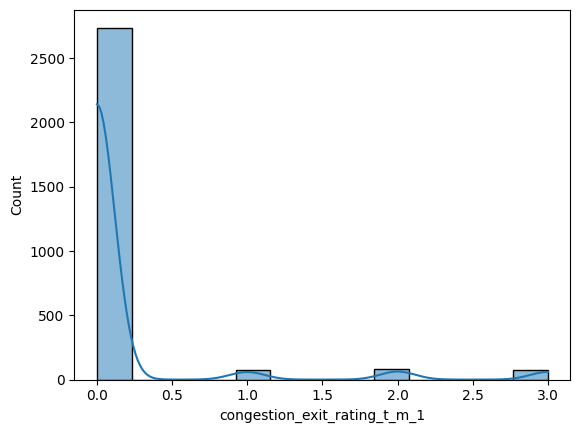

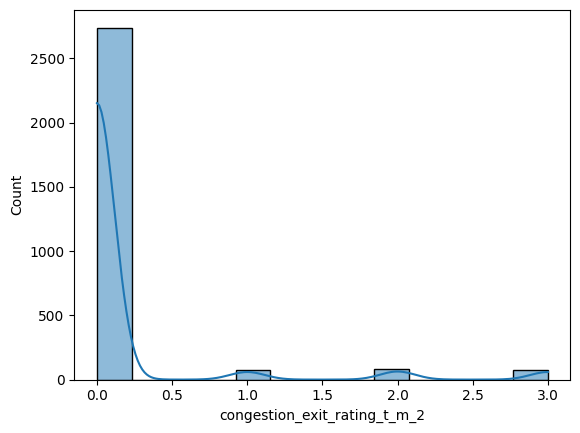

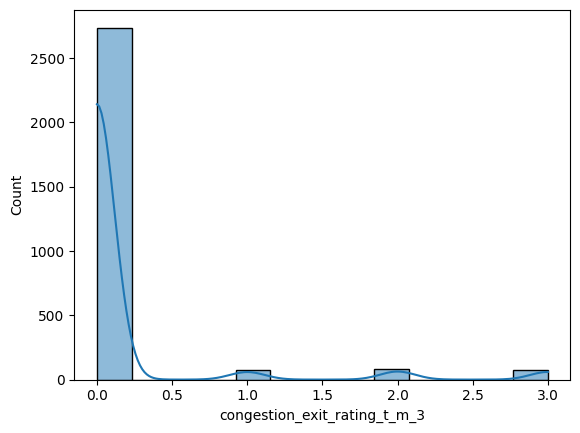

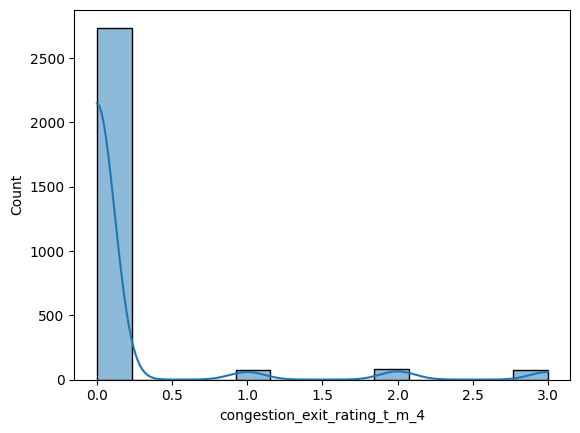

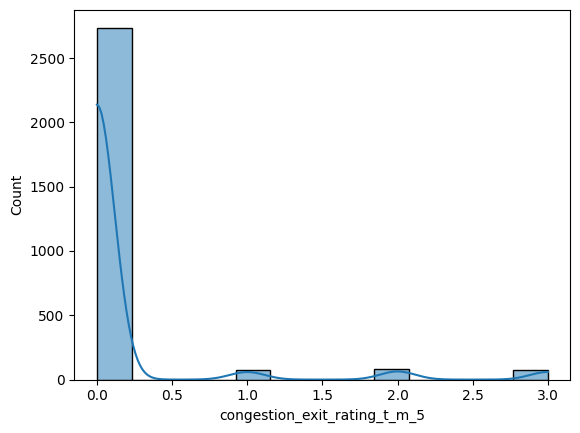

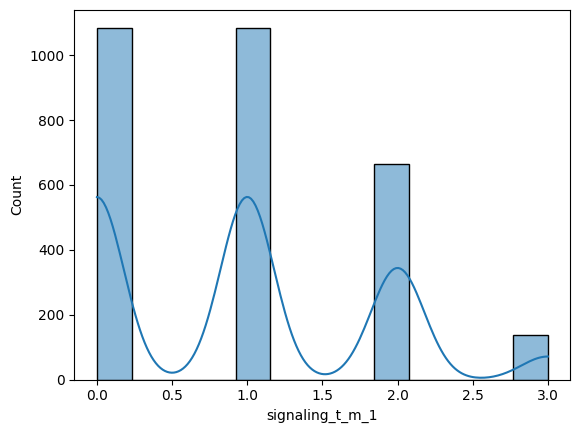

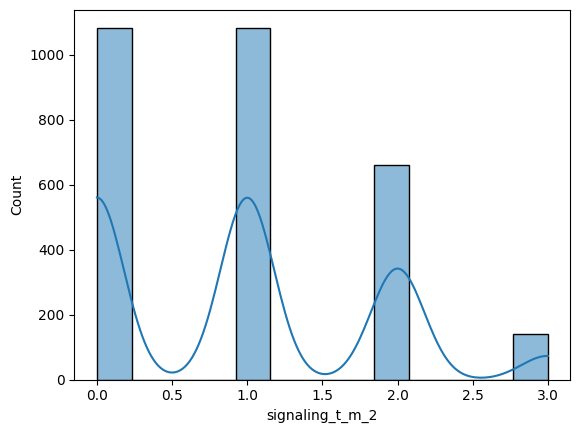

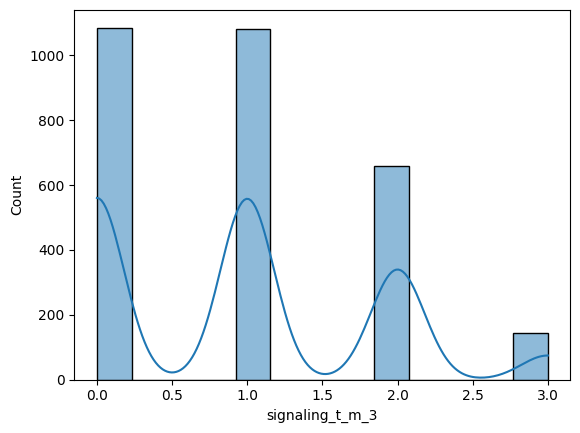

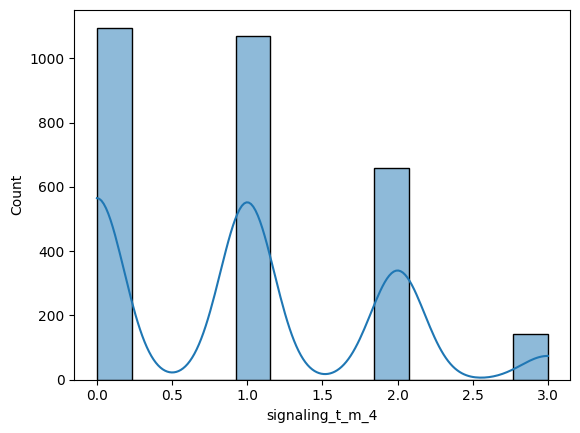

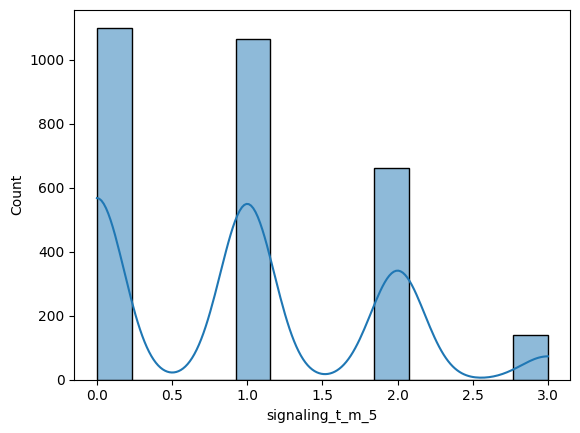

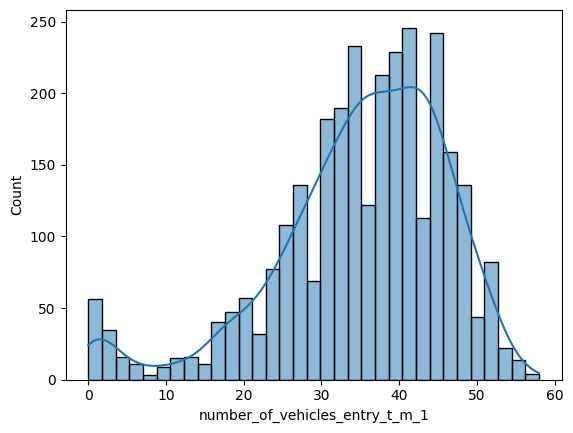

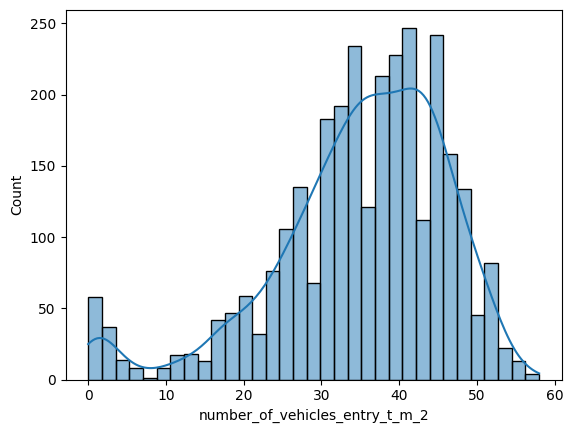

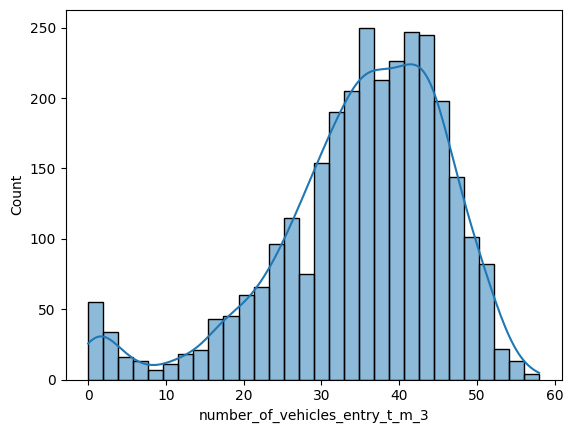

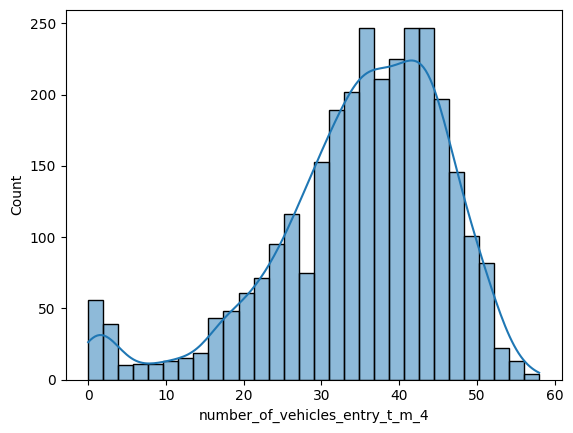

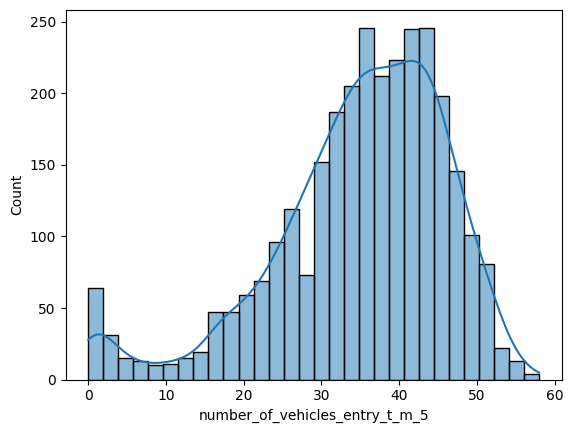

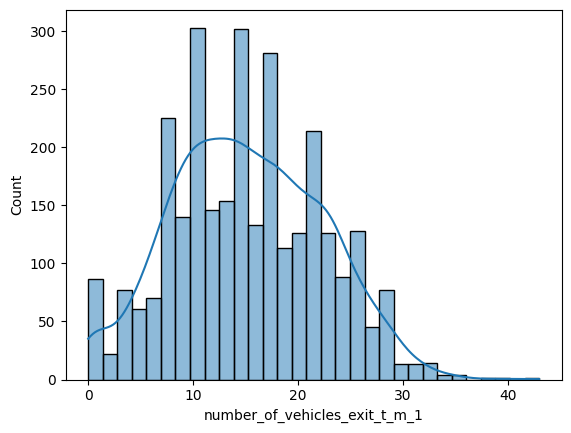

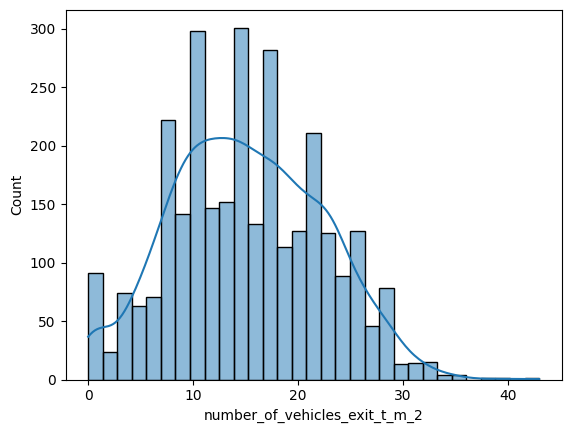

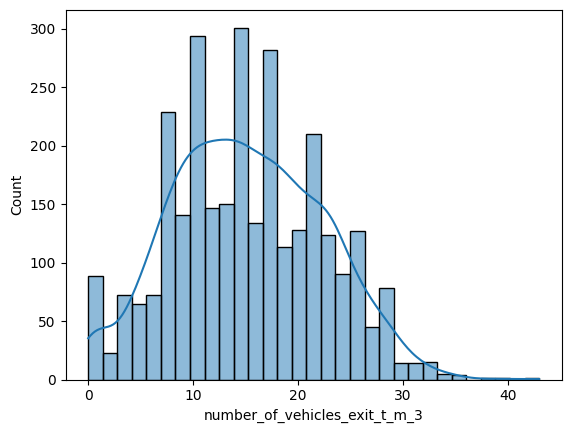

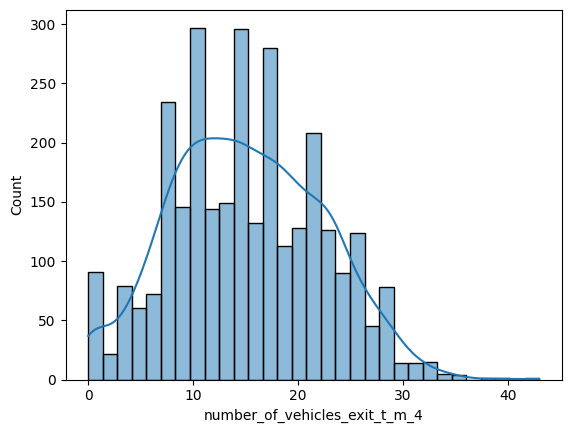

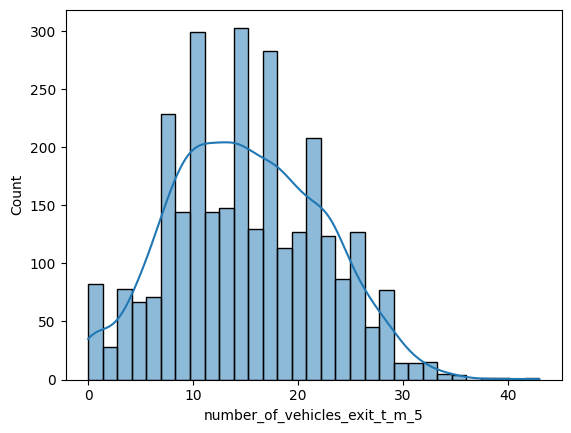

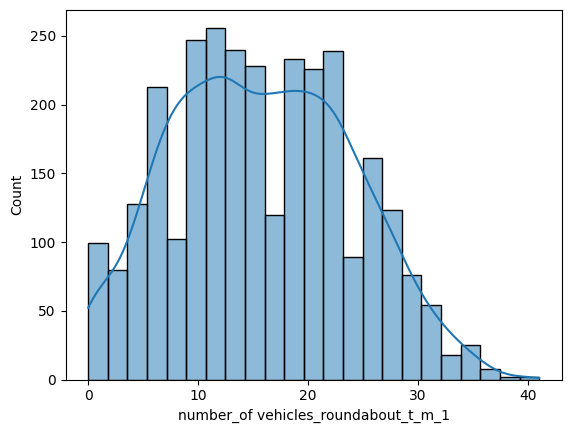

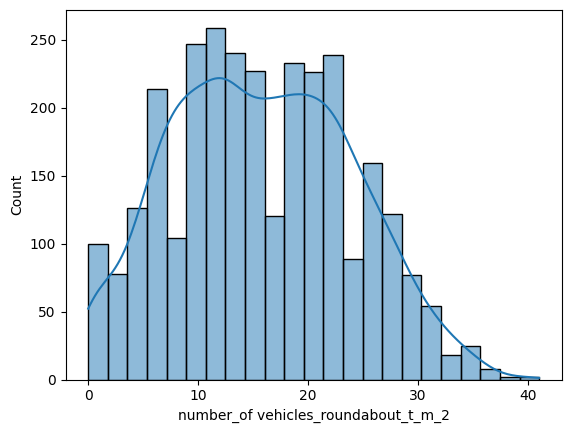

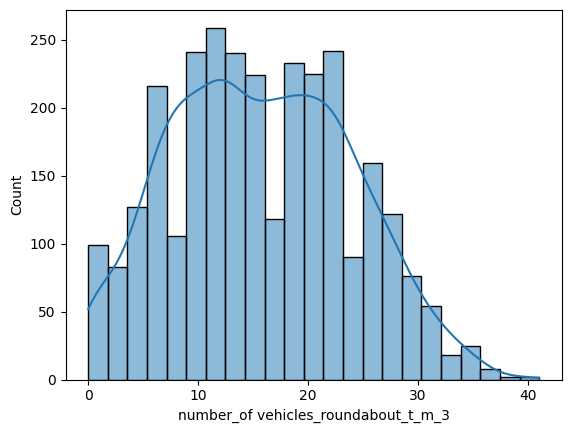

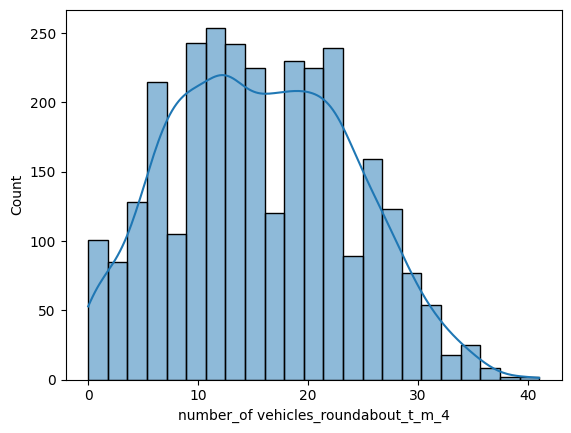

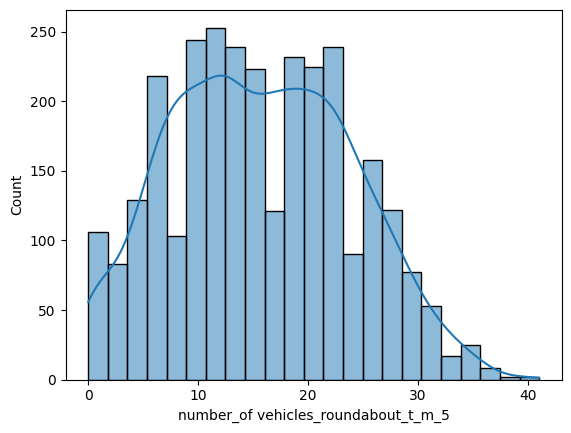

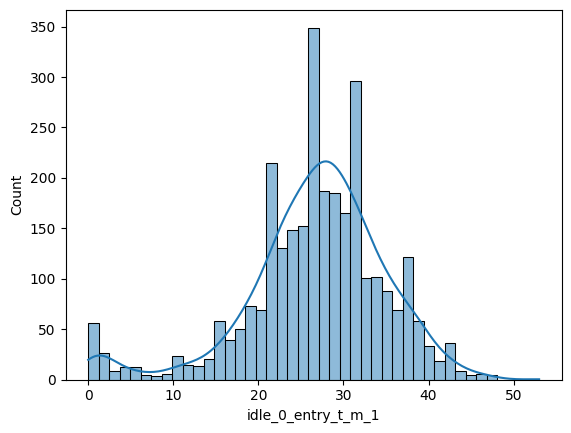

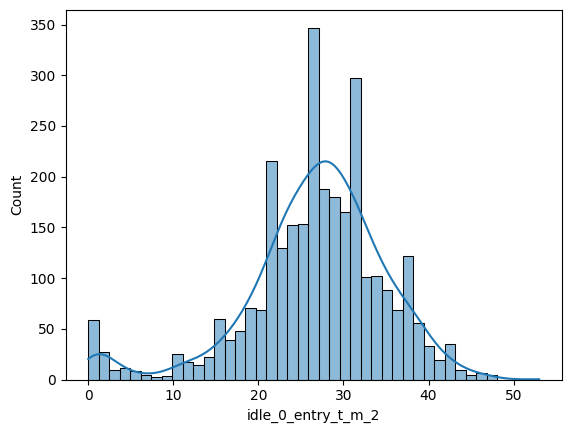

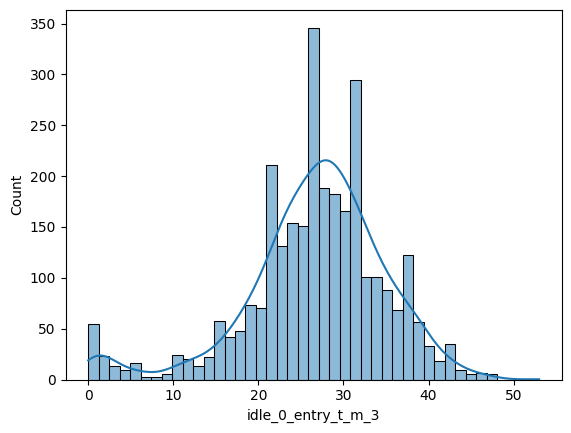

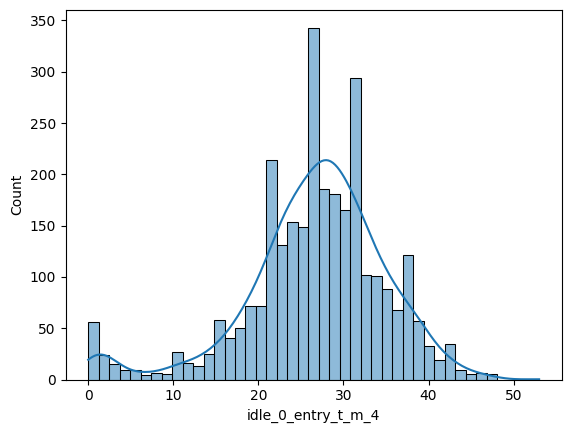

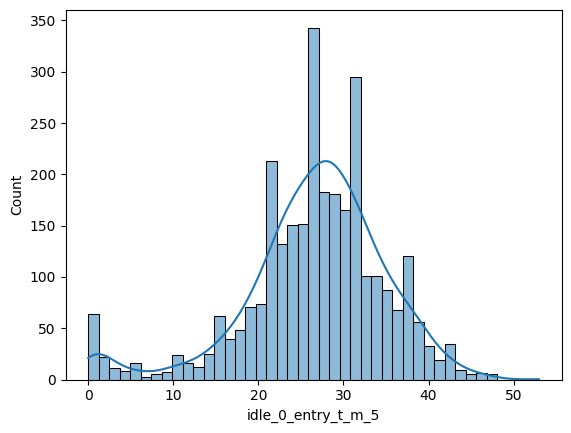

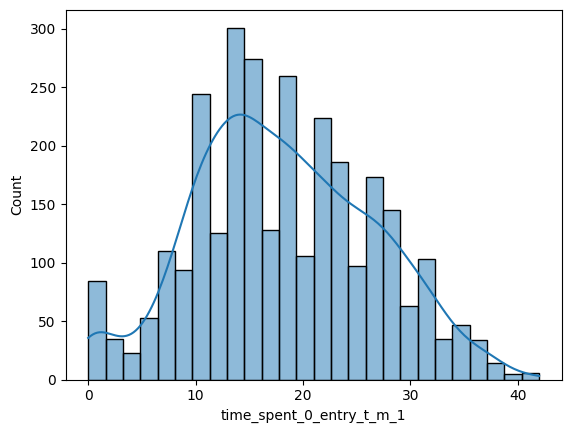

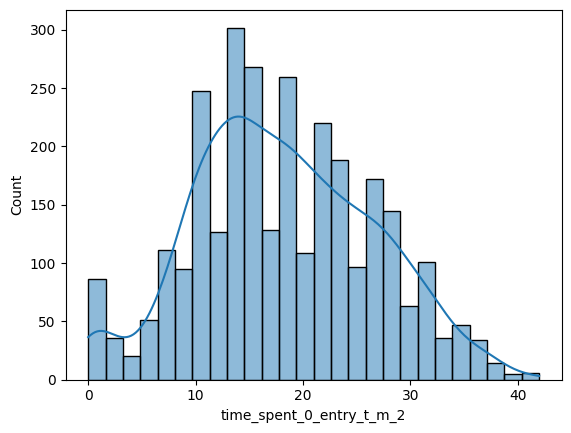

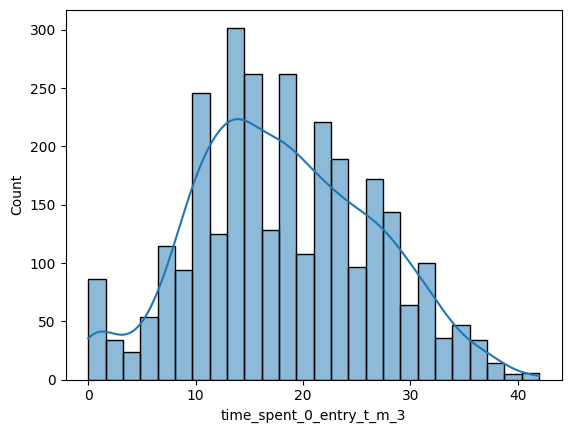

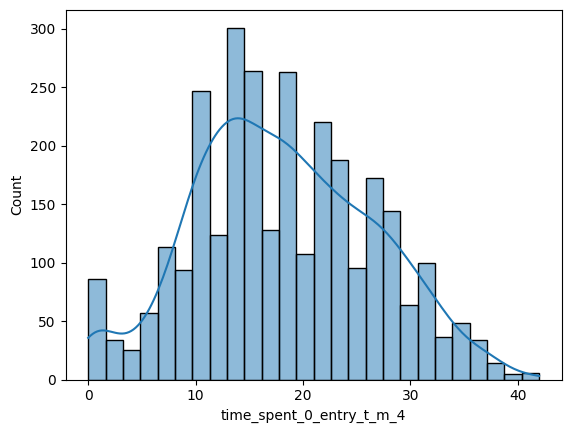

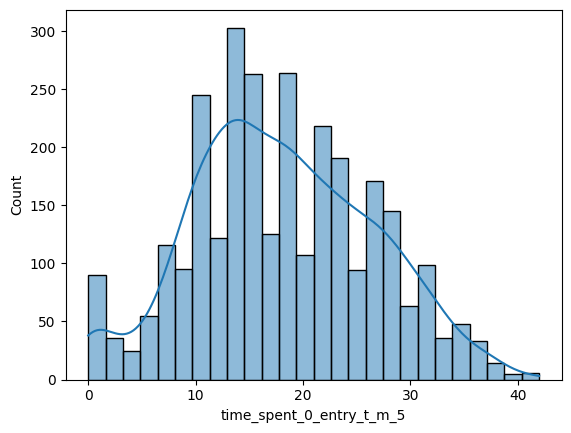

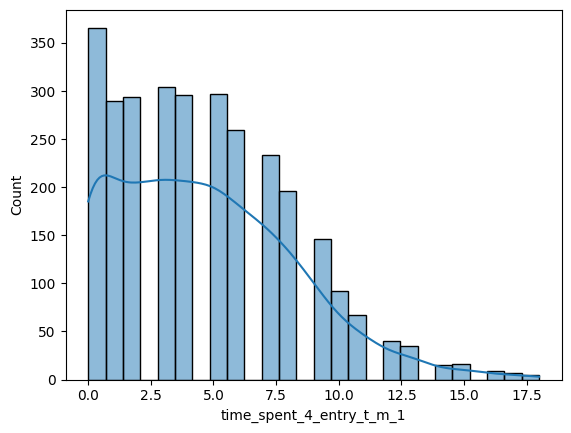

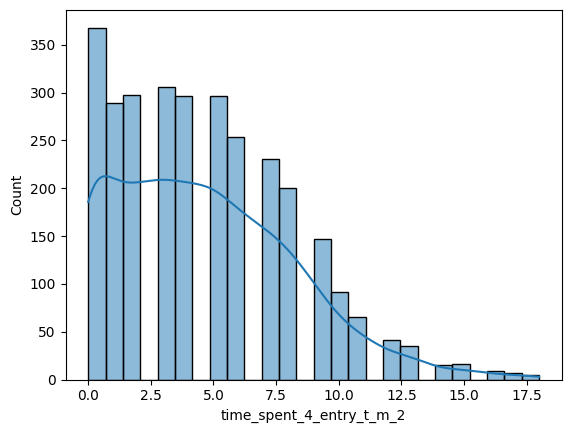

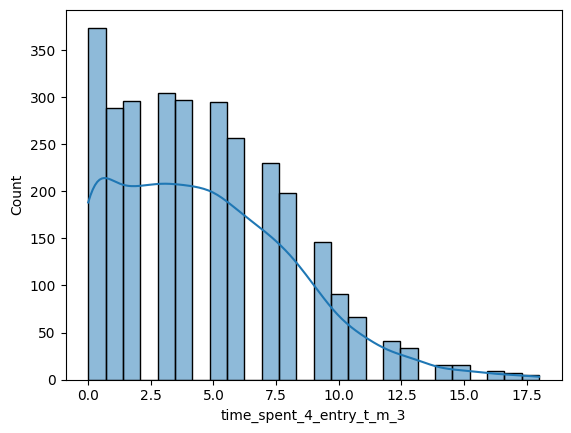

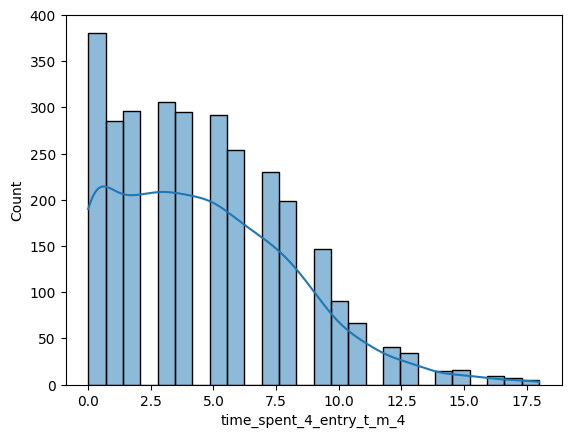

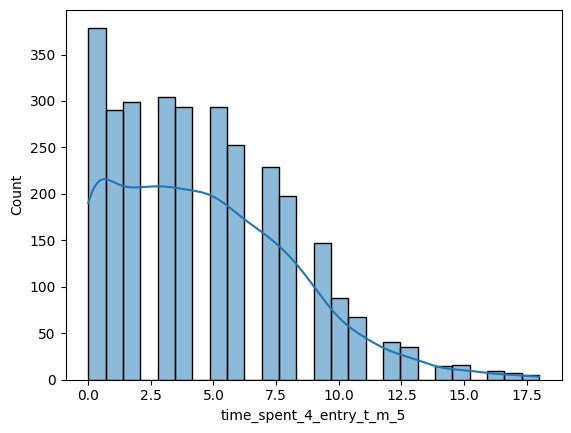

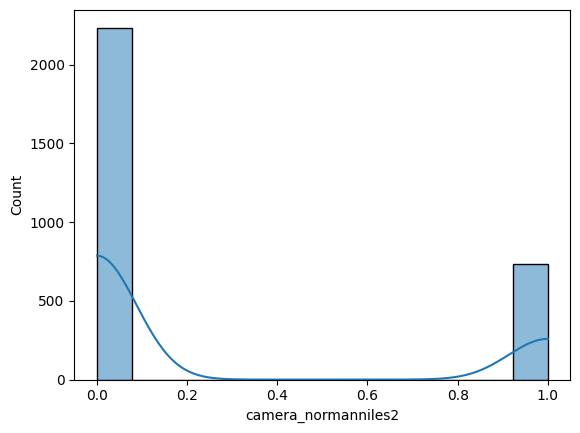

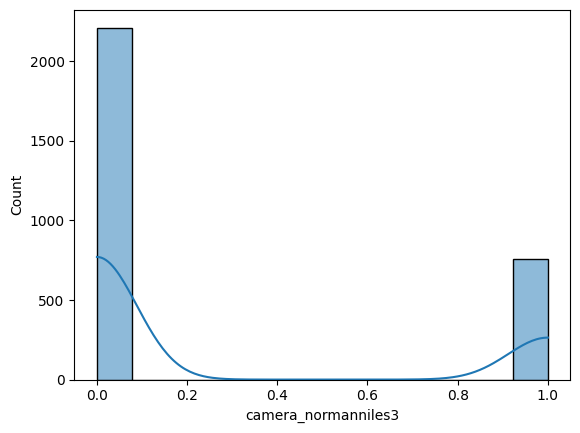

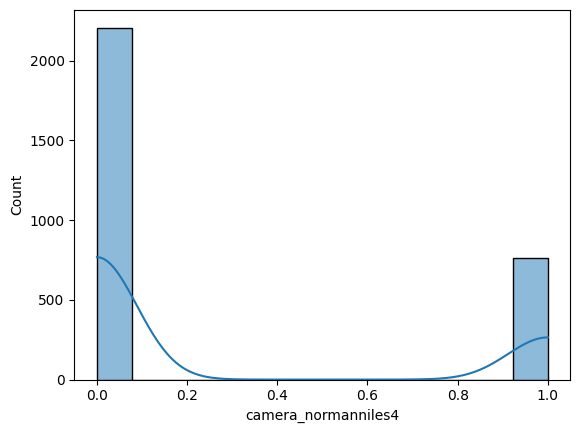

In [ ]:
# for col in X.columns:
#   sns.histplot(x=X[col], kde=True)
#   plt.show()

In [106]:
# def f1_macro_eval(raw_preds, eval_data):
#     # Extract true labels from the LightGBM Dataset
#     labels = eval_data.get_label().astype(int)
#     # Get the number of classes from the dataset parameters
#     num_class = int(eval_data.params["num_class"])

#     # Reshape the raw predictions into (num_samples, num_classes)
#     y_pred_proba = raw_preds.reshape(len(labels), num_class)
#     # Get the predicted class labels by taking the argmax along axis 1
#     y_pred_labels = np.argmax(y_pred_proba, axis=1)

#     f1 = f1_score(labels, y_pred_labels, average="macro", zero_division=0)
#     return "f1_macro", f1, True

# def accuracy_eval(raw_preds, eval_data):
#     # Extract true labels from the LightGBM Dataset
#     labels = eval_data.get_label().astype(int)
#     # Get the number of classes from the dataset parameters
#     num_class = int(eval_data.params["num_class"])

#     # Reshape the raw predictions into (num_samples, num_classes)
#     y_pred_proba = raw_preds.reshape(len(labels), num_class)
#     # Get the predicted class labels by taking the argmax along axis 1
#     y_pred_labels = np.argmax(y_pred_proba, axis=1)

#     acc = accuracy_score(labels, y_pred_labels)
#     return "accuracy", acc, True

In [111]:
def f1_macro_eval(y_true, y_pred):
    # For multiclass, y_pred from LGBMClassifier will be probabilities for each class
    # Convert probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    f1 = f1_score(y_true, y_pred_labels, average="macro", zero_division=0)
    return "f1_macro", f1, True

def accuracy_eval(y_true, y_pred):
    # For multiclass, y_pred from LGBMClassifier will be probabilities for each class
    # Convert probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_true, y_pred_labels)
    return "accuracy", acc, True

In [112]:
def oversampling(x_val, y_val, threshold=0.7):
  # Ensure y_val is a Pandas Series for consistent processing
  if not isinstance(y_val, pd.Series):
    y_val = pd.Series(y_val)

  class_counts = y_val.value_counts()
  majority_count = class_counts.max()
  target_count = int(majority_count * threshold)

  combined_df = x_val.copy()
  combined_df['target'] = y_val.values

  resampled_dfs = []
  for class_label in class_counts.index:
    class_df = combined_df[combined_df['target'] == class_label]
    current_count = len(class_df)
    if current_count < target_count:
      oversampled_df = class_df.sample(n=target_count, replace=True, random_state=42)
      resampled_dfs.append(oversampled_df)
    else:
      resampled_dfs.append(class_df)
  combined_resampled = pd.concat(resampled_dfs, ignore_index=True)
  y_resampled = combined_resampled['target'].copy()
  x_resampled = combined_resampled.drop(columns=['target'])
  return x_resampled, y_resampled

# LightGBM

In [108]:
def train_function(X, y, model_name, n_splits=5, save_model=True, save_dir='default', model_type='enter', oversample=True, params={}, f_eval='accuracy'):
  fold_results = []
  feature_importances = []
  model_list = []

  skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)

  print(f"\n{'='*75}")
  print(f"LightGBM CLASSIFIER: {n_splits} Windows x 5 Targets for {model_name}")
  print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
  print(f"{'='*75}\n")

  fold_num = 0
  for train_idx, val_idx in skf.split(X, y):
    fold_num += 1

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    if oversample:
      X_train, y_train = oversampling(X_train, y_train, 0.7)

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    params.update({'num_class' : len(np.unique(y))})

    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        valid_names=['valid'],
        feval = f_eval,
        callbacks = [
            lgb.early_stopping(stopping_rounds=500),
            lgb.log_evaluation(period=200)
        ]
    )

    y_pred_proba = model.predict(X_val)
    y_pred = np.argmax(y_pred_proba, axis=1)

    fold_acc = accuracy_score(y_val, y_pred)
    fold_f1_macro = f1_score(y_val, y_pred, average="macro", zero_division=0)

    fold_results.append({
        "fold": fold_num,
        "accuracy": fold_acc,
        "f1_macro": fold_f1_macro
    })

    feature_importances.append(model.feature_importance(importance_type='gain'))
    model_list.append(model)

    print(f"FOLD {fold_num} : ACCURACY = {fold_acc:.4f}, F1-MACRO = {fold_f1_macro:.4f}")

  fold_df = pd.DataFrame(fold_results)
  print(f"\n{'-'*75}")
  print(f"FINAL MEAN RESULTS (LightGBM)")
  print(f"Accuracy: {fold_df['accuracy'].mean():.4f}")
  print(f"F1-Macro: {fold_df['f1_macro'].mean():.4f}")
  print(f"{'-'*75}\n")

  if save_model:
    model_dir = os.path.join(save_dir, 'models', model_type)
    os.makedirs(model_dir, exist_ok=True)
    safe_name = model_name.replace('-', '_').replace('/', '_').lower()

    for fold_idx, fold_model in enumerate(model_list, 1):
      model_path = os.path.join(model_dir, f"{safe_name}_fold_{fold_idx}.txt")
      fold_model.save_model(model_path)

    results_path = os.path.join(model_dir, f'{safe_name}_results.csv')
    fold_df.to_csv(results_path, index=False)

    metadata = {
        'model_name': model_name,
        'timestamp': datetime.now().isoformat(),
        'n_folds': n_splits,
        'mean_accuracy': float(fold_df['accuracy'].mean()),
        'std_accuracy': float(fold_df['accuracy'].std()),
        'mean_f1_macro': float(fold_df['f1_macro'].mean()),
        'std_f1_macro': float(fold_df['f1_macro'].std()),
        'feature_count': len(X.columns)
    }
    metadata_path = os.path.join(model_dir, f'{safe_name}_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

  return {
      "model_name" : model_name,
      "fold_results" : fold_results,
      "feature_importances" : feature_importances,
      "models" : model_list
  }

In [109]:
experiment_name = "first_train_accuracy"
n_splits = 5
oversample = True
save_model = True
f_eval = accuracy_eval
save_dir = "LightGBM_Results"
model_type = "enter"

exit_models = {}
enter_models = {}

params = {
    'num_boost_round': 2000,
    'objective': 'multiclass',
    'metric': 'None',
    'path_smooth': 10,
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'class_weight': 'balanced',
    'min_child_samples': 20,
    'verbose': -1
}

for col in y_enter.columns:
  y = y_enter[col]
  enter_models[col] = train_function(
      X, y, f"enter-{col}", save_model=True,
      save_dir=save_dir, model_type=model_type,
      n_splits=n_splits, oversample=oversample,
      params=params, f_eval=f_eval
  )

print("All models trained")

all_accuracies = []
all_f1_macros = []

for col in y_enter:
  # Convert the list of fold results into a DataFrame
  fold_df = pd.DataFrame(enter_models[col]['fold_results'])
  all_accuracies.append(fold_df['accuracy'].mean())
  all_f1_macros.append(fold_df['f1_macro'].mean())

  overall_accuracy = np.mean(all_accuracies)
  overall_f1_macro = np.mean(all_f1_macros)

  overall_metrics = {
      'experiment_name': experiment_name,
      'timestamp': datetime.now().isoformat(),
      'overall_accuracy': float(overall_accuracy),
      'overall_f1_macro': float(overall_f1_macro),
      'enter_accuracies': [float(x) for x in all_accuracies[:5]],
      'enter_f1_macros': [float(x) for x in all_f1_macros[:5]],
  }

  os.makedirs(save_dir, exist_ok=True)
  overall_metrics_path = os.path.join(save_dir, 'overall_metrics.json')
  with open(overall_metrics_path, 'w') as f:
      json.dump(overall_metrics, f, indent=4)

  print(f"✓ Overall metrics saved to {overall_metrics_path}")


LightGBM CLASSIFIER: 5 Windows x 5 Targets for enter-congestion_enter_rating_t_1
Features: 165 | Samples: 2965

Training until validation scores don't improve for 500 rounds
[200]	valid's accuracy: 0.514334
[400]	valid's accuracy: 0.526138
[600]	valid's accuracy: 0.531197
[800]	valid's accuracy: 0.536256
[1000]	valid's accuracy: 0.543002
[1200]	valid's accuracy: 0.539629
[1400]	valid's accuracy: 0.536256
Early stopping, best iteration is:
[919]	valid's accuracy: 0.551433
FOLD 1 : ACCURACY = 0.5514, F1-MACRO = 0.4233
Training until validation scores don't improve for 500 rounds
[200]	valid's accuracy: 0.514334
[400]	valid's accuracy: 0.51602
Early stopping, best iteration is:
[52]	valid's accuracy: 0.532884
FOLD 2 : ACCURACY = 0.5329, F1-MACRO = 0.4353
Training until validation scores don't improve for 500 rounds
[200]	valid's accuracy: 0.548061
[400]	valid's accuracy: 0.55312
Early stopping, best iteration is:
[24]	valid's accuracy: 0.569983
FOLD 3 : ACCURACY = 0.5700, F1-MACRO = 0.45

In [ ]:
experiment_name = "first_train_f1-micro"
n_splits = 5
oversample = False
save_model = True
f_eval = f1_macro_eval
save_dir = "LightGBM_Results"
model_type = "enter"

exit_models = {}
enter_models = {}

params = {
    'objective': 'multiclass',
    'metric': 'None',
    'path_smooth': 10,
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'class_weight': 'balanced',
    'min_child_samples': 20,
    'verbose': -1
}

for col in y_enter.columns:
  y = y_enter[col]
  enter_models[col] = train_function(
      X, y, f"enter-{col}", save_model=True,
      save_dir=save_dir, model_type=model_type,
      n_splits=n_splits, oversample=oversample,
      params=params, f_eval=f_eval
  )

print("All models trained")

all_accuracies = []
all_f1_macros = []

for col in y_enter:
  # Convert the list of fold results into a DataFrame
  fold_df = pd.DataFrame(enter_models[col]['fold_results'])
  all_accuracies.append(fold_df['accuracy'].mean())
  all_f1_macros.append(fold_df['f1_macro'].mean())

  overall_accuracy = np.mean(all_accuracies)
  overall_f1_macro = np.mean(all_f1_macros)

  overall_metrics = {
      'experiment_name': experiment_name,
      'timestamp': datetime.now().isoformat(),
      'overall_accuracy': float(overall_accuracy),
      'overall_f1_macro': float(overall_f1_macro),
      'enter_accuracies': [float(x) for x in all_accuracies[:5]],
      'enter_f1_macros': [float(x) for x in all_f1_macros[:5]],
  }

  os.makedirs(save_dir, exist_ok=True)
  overall_metrics_path = os.path.join(save_dir, 'overall_metrics.json')
  with open(overall_metrics_path, 'w') as f:
      json.dump(overall_metrics, f, indent=4)

  print(f"✓ Overall metrics saved to {overall_metrics_path}")


LightGBM CLASSIFIER: 5 Windows x 5 Targets for enter-congestion_enter_rating_t_1
Features: 164 | Samples: 2965

Training until validation scores don't improve for 500 rounds
[200]	valid's f1_macro: 0.420016
[400]	valid's f1_macro: 0.431634
[600]	valid's f1_macro: 0.423874
[800]	valid's f1_macro: 0.421953
[1000]	valid's f1_macro: 0.421419
Early stopping, best iteration is:
[586]	valid's f1_macro: 0.444223
FOLD 1 : ACCURACY = 0.5396, F1-MACRO = 0.4442
Training until validation scores don't improve for 500 rounds
[200]	valid's f1_macro: 0.430753
[400]	valid's f1_macro: 0.440249
[600]	valid's f1_macro: 0.42529
[800]	valid's f1_macro: 0.425529
Early stopping, best iteration is:
[491]	valid's f1_macro: 0.447105
FOLD 2 : ACCURACY = 0.5464, F1-MACRO = 0.4471
Training until validation scores don't improve for 500 rounds
[200]	valid's f1_macro: 0.428934
[400]	valid's f1_macro: 0.432985
[600]	valid's f1_macro: 0.439816
[800]	valid's f1_macro: 0.441377
[1000]	valid's f1_macro: 0.432776
Early stop

In [ ]:
!zip -r lightgbm_results_01.zip LightGBM_Results

  adding: LightGBM_Results/ (stored 0%)
  adding: LightGBM_Results/overall_metrics.json (deflated 50%)
  adding: LightGBM_Results/models/ (stored 0%)
  adding: LightGBM_Results/models/enter/ (stored 0%)
  adding: LightGBM_Results/models/enter/enter_congestion_enter_rating_t_2_fold_4.txt (deflated 63%)
  adding: LightGBM_Results/models/enter/enter_congestion_enter_rating_t_3_fold_5.txt (deflated 63%)
  adding: LightGBM_Results/models/enter/enter_congestion_enter_rating_t_1_fold_2.txt (deflated 63%)
  adding: LightGBM_Results/models/enter/enter_congestion_enter_rating_t_2_fold_3.txt (deflated 62%)
  adding: LightGBM_Results/models/enter/enter_congestion_enter_rating_t_3_fold_3.txt (deflated 63%)
  adding: LightGBM_Results/models/enter/enter_congestion_enter_rating_t_4_results.csv (deflated 41%)
  adding: LightGBM_Results/models/enter/enter_congestion_enter_rating_t_3_fold_2.txt (deflated 63%)
  adding: LightGBM_Results/models/enter/enter_congestion_enter_rating_t_2_metadata.json (deflate

# Functions

In [ ]:
def train_function(x, y, n_splits, f_eval, model_config):
  pass

# My Approach


LightGBM CLASSIFIER: Fold 1/5 - Training for 5 Targets
Features: 165 | Train Samples: 2372 | Val Samples: 593

  Training model for target: congestion_enter_rating_t_1
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's f1_macro: 0.432022
  Training model for target: congestion_enter_rating_t_2
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's f1_macro: 0.427588
  Training model for target: congestion_enter_rating_t_3
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's f1_macro: 0.439995
  Training model for target: congestion_enter_rating_t_4
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's f1_macro: 0.452623
  Training model for target: congestion_enter_rating_t_5
Training until validation 

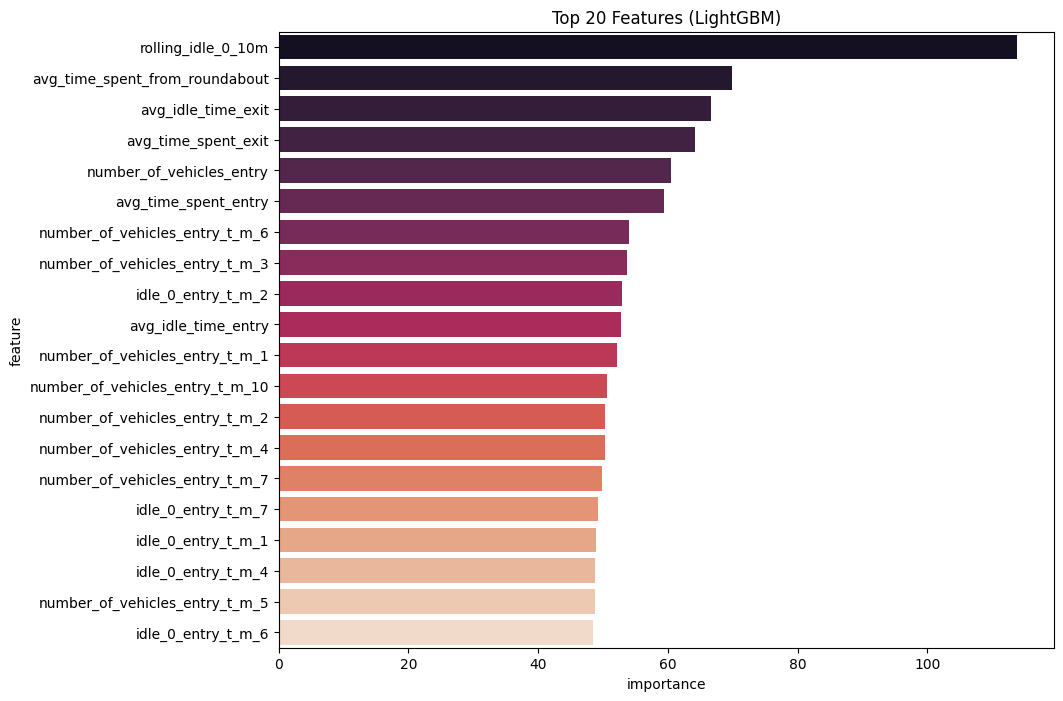

In [116]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# CHANGE 1: Import LightGBM
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold # Changed from TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score

# --- CONFIGURATION (Optimized for LightGBM) ---
n_splits = 5
f_eval = f1_macro_eval
# f_eval = accuracy_eval

model_config = {
    'learning_rate': 0.05,
    'num_leaves': 20,
    'min_child_samples': 20,
    'objective': 'multiclass',
    'metric': 'None',
    'class_weight': 'balanced',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)

# --- 2. SETUP ---
target_cols = y_enter.columns.tolist()

model_dir = 'lightgbmClassifier_01'
os.makedirs(model_dir, exist_ok=True)

# --- 3. TRAINING LOOP ---
all_fold_results = []  # To store overall accuracy and F1 for each fold
all_feature_importances = []  # To store feature importances from all models

fold_num = 0
# The outer loop iterates through each cross-validation fold
for train_idx, val_idx in skf.split(X, y_enter[target_cols[0]]): # Stratify based on the first target column
    fold_num += 1

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    # y_train_df and y_val_df now contain all target columns for the current fold
    y_train_df, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]

    # List to hold predictions for all 5 target columns for the current fold's validation set
    current_fold_all_target_preds = []

    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    print(f"\n{'='*75}")
    print(f"LightGBM CLASSIFIER: Fold {fold_num}/{n_splits} - Training for {len(target_cols)} Targets")
    print(f"Features: {X.shape[1]} | Train Samples: {X_train.shape[0]} | Val Samples: {X_val.shape[0]}")
    print(f"{'='*75}\n")

    # The inner loop trains a separate model for each target column
    for col in target_cols:
        print(f"  Training model for target: {col}")
        model = LGBMClassifier(**model_config)

        model.fit(
            X_train, y_train_df[col], # Train on the specific target column for this model
            eval_set=[(X_val, y_val_df[col])], # Evaluate on the specific target column for this model
            eval_metric=f_eval, # Use the custom evaluation metric
            callbacks=[
                early_stopping(stopping_rounds=500),
                log_evaluation(period=200)
            ]
        )

        # Save the model
        model.booster_.save_model(os.path.join(fold_path, f'model_{col}.txt'))

        # Get predictions for the current target and append to the list for this fold
        current_fold_all_target_preds.append(model.predict(X_val))

        # Capture Importance for this specific model
        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_feature_importances.append(imp_df)

    # --- 4. EVALUATION FOR THIS FOLD ---
    # After all models for the current fold have been trained and predictions made
    # Combine predictions and true values for overall fold evaluation

    # `current_fold_all_target_preds` will contain 5 arrays, each of shape (N_val_fold,).
    # Stacking them will result in (N_val_fold, 5).
    y_pred_final_this_fold = np.column_stack(current_fold_all_target_preds)
    # `y_val_df` for this fold is already (N_val_fold, 5).
    y_val_flat_this_fold = y_val_df.to_numpy().flatten()
    y_pred_flat_this_fold = y_pred_final_this_fold.flatten()

    fold_acc = accuracy_score(y_val_flat_this_fold, y_pred_flat_this_fold)
    fold_f1_macro = f1_score(y_val_flat_this_fold, y_pred_flat_this_fold, average="macro", zero_division=0)

    all_fold_results.append({"fold": fold_num, "accuracy": fold_acc, "f1_macro": fold_f1_macro})
    print(f"\nFold {fold_num:02d} - Overall Metrics: Accuracy={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# --- 5. SUMMARY (After ALL folds are complete) ---
fold_df = pd.DataFrame(all_fold_results)
total_importance_df = pd.concat(all_feature_importances)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

config_to_save = model_config.copy()

metadata = {
    'model_type': 'LGBMClassifier',
    'timestamp': datetime.now().isoformat(),
    'n_folds': n_splits,
    'all_fold_results': all_fold_results,
    'mean_accuracy': float(fold_df['accuracy'].mean()),
    'std_accuracy': float(fold_df['accuracy'].std()),
    'mean_f1_macro': float(fold_df['f1_macro'].mean()),
    'top_5_features': global_importance['feature'].tolist(),
    'model_config': config_to_save,
}

with open(os.path.join(model_dir, 'summary_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n{'-'*75}")
print(f"FINAL MEAN RESULTS (LightGBM)")
print(f"Accuracy: {fold_df['accuracy'].mean():.4f}")
print(f"F1-Macro: {fold_df['f1_macro'].mean():.4f}")
print(f"{'-'*75}\n")

# Plot Top Features
plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')
plt.title('Top 20 Features (LightGBM)')
plt.show()

In [39]:
!zip -r lightgbmClassifier_f1_macro.zip lightgbmClassifier_01

  adding: lightgbmClassifier_01/ (stored 0%)
  adding: lightgbmClassifier_01/fold_2/ (stored 0%)
  adding: lightgbmClassifier_01/fold_2/model_congestion_enter_rating_t_2.txt (deflated 62%)
  adding: lightgbmClassifier_01/fold_2/model_congestion_enter_rating_t_1.txt (deflated 62%)
  adding: lightgbmClassifier_01/fold_2/model_congestion_enter_rating_t_4.txt (deflated 63%)
  adding: lightgbmClassifier_01/fold_2/model_congestion_enter_rating_t_5.txt (deflated 62%)
  adding: lightgbmClassifier_01/fold_2/model_congestion_enter_rating_t_3.txt (deflated 63%)
  adding: lightgbmClassifier_01/fold_1/ (stored 0%)
  adding: lightgbmClassifier_01/fold_1/model_congestion_enter_rating_t_2.txt (deflated 62%)
  adding: lightgbmClassifier_01/fold_1/model_congestion_enter_rating_t_1.txt (deflated 62%)
  adding: lightgbmClassifier_01/fold_1/model_congestion_enter_rating_t_4.txt (deflated 62%)
  adding: lightgbmClassifier_01/fold_1/model_congestion_enter_rating_t_5.txt (deflated 62%)
  adding: lightgbmClass

# Removed SMOTE & added sample weight


XGBoost: 5 Windows x 5 Targets
Features: 91 | Samples: 2969

Window 01: Acc=0.3960 | F1-Macro=0.2564
Window 02: Acc=0.3939 | F1-Macro=0.3388
Window 03: Acc=0.5810 | F1-Macro=0.4187
Window 04: Acc=0.3279 | F1-Macro=0.3140
Window 05: Acc=0.4364 | F1-Macro=0.4162

---------------------------------------------------------------------------
FINAL MEAN RESULTS
Accuracy: 0.4270
F1-Macro: 0.3488
---------------------------------------------------------------------------



/tmp/ipython-input-3229248955.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')


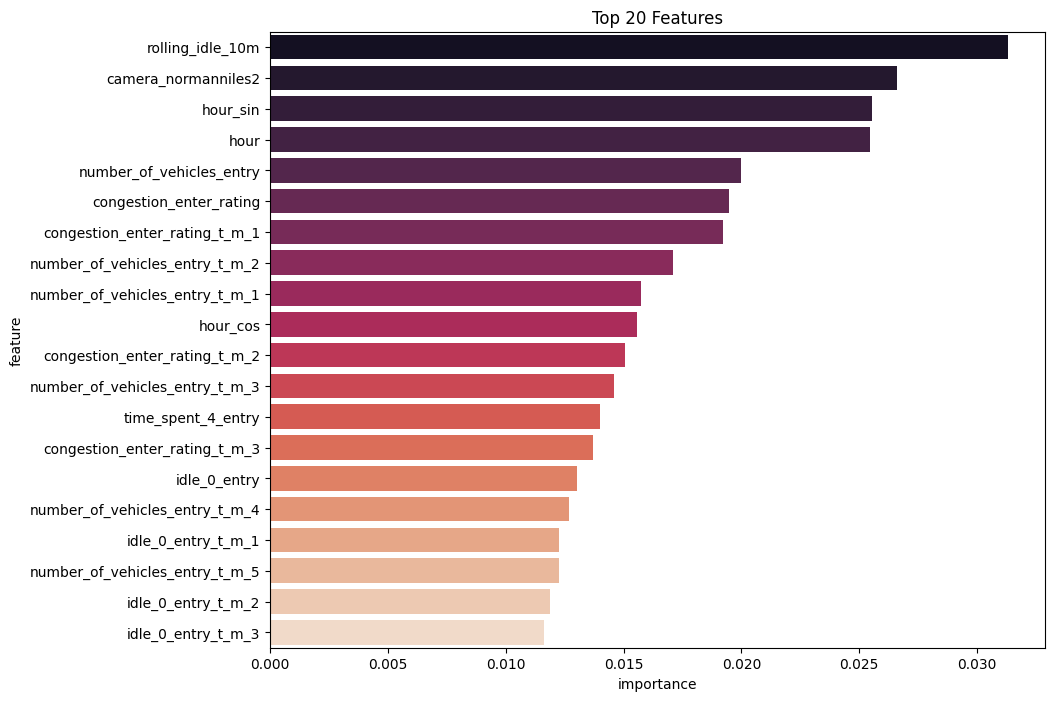

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

model_config = {
        'n_estimators': 1500,
        'learning_rate': 0.02,
        'max_depth': 6,
        'min_child_weight': 5,
        'max_delta_step': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'early_stopping_rounds': 50,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'tree_method': 'hist',
        'gamma': 0.2,
    }

# --- 1. FEATURE ENGINEERING (Trend & Momentum) ---
# We add these before the split so the model sees the "flow" of traffic
X = X.copy()
# Is traffic getting worse or better?
X['congestion_diff'] = X['congestion_enter_rating'] - X['congestion_enter_rating_t_m_1']

# Acceleration: Is the rate of vehicle entry increasing?
X['veh_accel'] = X['number_of_vehicles_entry'] - X['number_of_vehicles_entry_t_m_1']

# Rolling standard deviation: High variance often precedes a state change (transition)
X['rolling_veh_std_5m'] = X['number_of_vehicles_entry'].rolling(window=5).std().fillna(0)

X['rolling_idle_10m'] = X['idle_0_entry'].rolling(window=10).mean().fillna(0)

# Binary flag for rush hour periods
X['is_rush_hour'] = X['hour'].apply(lambda x: 1 if x in [7,8,9,16,17,18] else 0)

# --- 2. Setup & Configuration ---
n_splits = 5 # Reduced splits to give SMOTE more samples to work with
tscv = TimeSeriesSplit(n_splits=n_splits)
target_cols = y_enter.columns.tolist()

model_dir = 'xgboost_classifier_optimized'
os.makedirs(model_dir, exist_ok=True)

fold_results = []
all_importances = []

print(f"\n{'='*75}")
print(f"XGBoost: {n_splits} Windows x {len(target_cols)} Targets")
print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
print(f"{'='*75}\n")

# --- 3. Training Loop ---
fold_num = 0
for train_idx, val_idx in tscv.split(X):
    fold_num += 1

    # Sequential Split
    X_train_fold, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]

    all_target_preds = []
    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    for col in target_cols:
        weights = compute_sample_weight(class_weight='balanced', y=y_train_fold[col])
        val_weights = compute_sample_weight(class_weight='balanced', y=y_val_df[col])

        # B. Initialize XGBoost with Aggressive Hyperparameters
        model = XGBClassifier(
            **model_config
        )

        model.fit(
            X_train_fold, y_train_fold[col],
            sample_weight=weights,
            eval_set=[(X_val, y_val_df[col])],
            sample_weight_eval_set=[val_weights],
            verbose=False
        )

        # Predict
        all_target_preds.append(model.predict(X_val))

        # Save Model
        model.save_model(os.path.join(fold_path, f'model_{col}.json'))

        # Capture Importance
        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_importances.append(imp_df)

    # --- 4. Evaluation ---
    y_pred_final = np.column_stack(all_target_preds)
    y_val_flat = y_val_df.to_numpy().flatten()
    y_pred_flat = y_pred_final.flatten()

    fold_acc = accuracy_score(y_val_flat, y_pred_flat)
    fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

    fold_results.append({"fold": fold_num, "accuracy": fold_acc, "f1_macro": fold_f1_macro})
    print(f"Window {fold_num:02d}: Acc={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# --- 5. Aggregation & Summary ---
fold_df = pd.DataFrame(fold_results)
total_importance_df = pd.concat(all_importances)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

metadata = {
    'model_type': 'XGBoostClassifier',
    'timestamp': datetime.now().isoformat(),
    'n_folds': n_splits,
    'mean_accuracy': float(fold_df['accuracy'].mean()),
    'std_accuracy': float(fold_df['accuracy'].std()),
    'mean_f1_macro': float(fold_df['f1_macro'].mean()),
    'top_5_features': global_importance['feature'].head(5).tolist(),
    'model_config': model_config,
}

with open(os.path.join(model_dir, 'summary_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n{'-'*75}")
print(f"FINAL MEAN RESULTS")
print(f"Accuracy: {fold_df['accuracy'].mean():.4f}")
print(f"F1-Macro: {fold_df['f1_macro'].mean():.4f}")
print(f"{'-'*75}\n")

# Plot Top Features
plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')
plt.title('Top 20 Features')
plt.show()

In [ ]:
!zip -r compute_sample_weight_removedSMOTE_changed_loss.zip compute_sample_weight_removedSMOTE

  adding: compute_sample_weight_removedSMOTE/ (stored 0%)
  adding: compute_sample_weight_removedSMOTE/fold_1/ (stored 0%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_1.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_3.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_5.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_4.json (deflated 76%)
  adding: compute_sample_weight_removedSMOTE/fold_1/model_congestion_enter_rating_t_2.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_5/ (stored 0%)
  adding: compute_sample_weight_removedSMOTE/fold_5/model_congestion_enter_rating_t_1.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_5/model_congestion_enter_rating_t_3.json (deflated 75%)
  adding: compute_sample_weight_removedSMOTE/fold_5/model_congestion_e

# TimeSeriesSplit + SMOTE


XGBoost + SMOTE TIME-SERIES: 5 Windows x 5 Targets
Features: 88 | Samples: 2969

Window 01: Acc=0.4866 | F1-Macro=0.2570
Window 02: Acc=0.4368 | F1-Macro=0.3415
Window 03: Acc=0.5854 | F1-Macro=0.3977
Window 04: Acc=0.3866 | F1-Macro=0.3218
Window 05: Acc=0.5000 | F1-Macro=0.4138

---------------------------------------------------------------------------
FINAL MEAN RESULTS (SMOTE + TIME-SERIES)
Accuracy: 0.4791
F1-Macro: 0.3463
---------------------------------------------------------------------------



/tmp/ipython-input-3075189265.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')


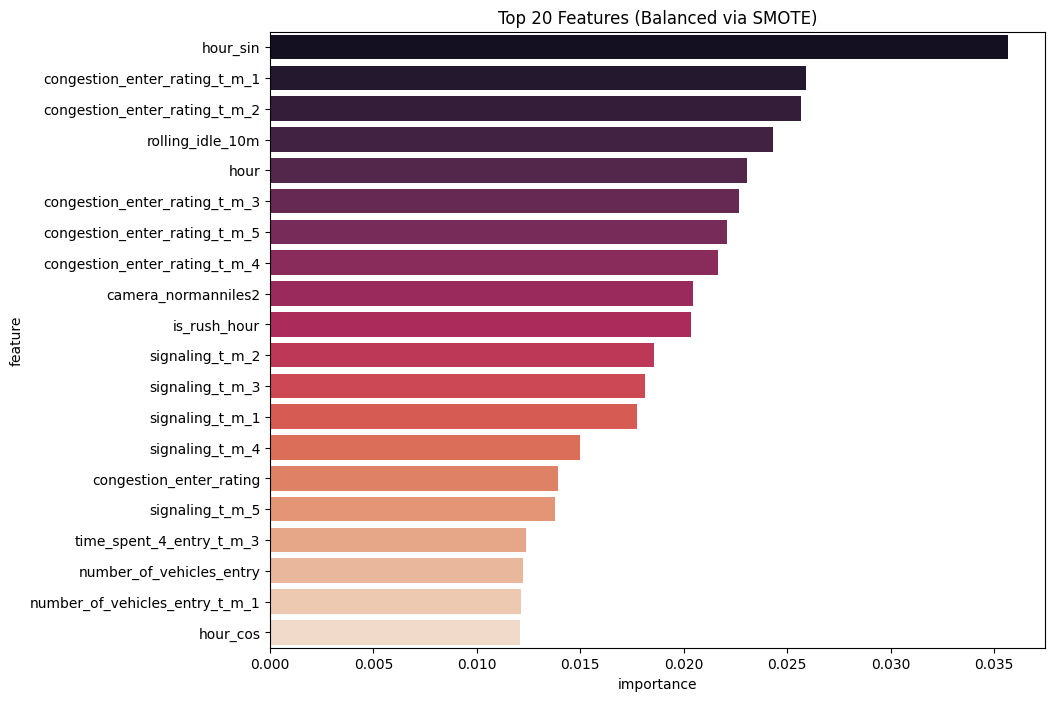

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score
# from imblearn.over_sampling import SMOTE

model_config = {
        'n_estimators': 2000,
        'learning_rate': 0.05,
        'max_depth': 5,
        'min_child_weight': 1,
        'max_delta_step': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'early_stopping_rounds': 50,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'tree_method': 'hist',
        'gamma': 0.1,
    }

# --- 1. FEATURE ENGINEERING (Trend & Momentum) ---
# We add these before the split so the model sees the "flow" of traffic
X = X.copy()
# Delta: Is congestion increasing or decreasing?
# X['idle_trend'] = X['idle_0_entry'] - X['idle_0_entry_t_m_1']
# X['veh_trend'] = X['number_of_vehicles_entry'] - X['number_of_vehicles_entry_t_m_1']
# Smooth out sensor noise with a rolling average
X['rolling_idle_10m'] = X['idle_0_entry'].rolling(window=10).mean().fillna(0)
# Binary flag for rush hour periods
X['is_rush_hour'] = X['hour'].apply(lambda x: 1 if x in [7,8,9,16,17,18] else 0)

# --- 2. Setup & Configuration ---
n_splits = 5 # Reduced splits to give SMOTE more samples to work with
tscv = TimeSeriesSplit(n_splits=n_splits)
target_cols = y_enter.columns.tolist()

# SMOTE configuration
# k_neighbors is small because your dataset is small (~1100 samples)
# smote = SMOTE(random_state=42, k_neighbors=5)

model_dir = 'traffic_smote_analysis'
os.makedirs(model_dir, exist_ok=True)

fold_results = []
all_importances = []

print(f"\n{'='*75}")
print(f"XGBoost + SMOTE TIME-SERIES: {n_splits} Windows x {len(target_cols)} Targets")
print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
print(f"{'='*75}\n")

# --- 3. Training Loop ---
fold_num = 0
for train_idx, val_idx in tscv.split(X):
    fold_num += 1

    # Sequential Split
    X_train_fold, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]

    all_target_preds = []
    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    for col in target_cols:
        # A. Apply SMOTE only to training for the current target
        # This addresses the imbalance in each specific 1-5 minute window
        # try:
        #     X_resampled, y_resampled = smote.fit_resample(X_train_fold, y_train_fold[col])
        # except ValueError:
            # Fallback if a class has fewer than k_neighbors
        X_resampled, y_resampled = X_train_fold, y_train_fold[col]
            # print(f"Warning: SMOTE skipped for {col} in Fold {fold_num} (too few samples).")

        # B. Initialize XGBoost with Aggressive Hyperparameters
        model = XGBClassifier(
            **model_config
        )

        # C. Fit on resampled data
        model.fit(
            X_resampled, y_resampled,
            eval_set=[(X_val, y_val_df[col])],
            verbose=False
        )

        # D. Save & Predict
        model.save_model(os.path.join(fold_path, f'model_{col}.json'))
        all_target_preds.append(model.predict(X_val))

        # Capture Importance
        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_importances.append(imp_df)

    # --- 4. Evaluation ---
    y_pred_final = np.column_stack(all_target_preds)
    y_val_flat = y_val_df.to_numpy().flatten()
    y_pred_flat = y_pred_final.flatten()

    fold_acc = accuracy_score(y_val_flat, y_pred_flat)
    fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

    fold_results.append({"fold": fold_num, "accuracy": fold_acc, "f1_macro": fold_f1_macro})
    print(f"Window {fold_num:02d}: Acc={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# --- 5. Aggregation & Summary ---
fold_df = pd.DataFrame(fold_results)
total_importance_df = pd.concat(all_importances)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

metadata = {
    'model_type': 'XGBoostClassifier',
    'timestamp': datetime.now().isoformat(),
    'n_folds': n_splits,
    'mean_accuracy': float(fold_df['accuracy'].mean()),
    'std_accuracy': float(fold_df['accuracy'].std()),
    'mean_f1_macro': float(fold_df['f1_macro'].mean()),
    'top_5_features': global_importance['feature'].head(5).tolist(),
    'model_config': model_config,
}

with open(os.path.join(model_dir, 'summary_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n{'-'*75}")
print(f"FINAL MEAN RESULTS (SMOTE + TIME-SERIES)")
print(f"Accuracy: {fold_df['accuracy'].mean():.4f}")
print(f"F1-Macro: {fold_df['f1_macro'].mean():.4f}")
print(f"{'-'*75}\n")

# Plot Top Features
plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='rocket')
plt.title('Top 20 Features (Balanced via SMOTE)')
plt.show()

In [ ]:
!zip -r updated_yolo_traffic_smote_analysis.zip traffic_smote_analysis

updating: traffic_smote_analysis/ (stored 0%)
updating: traffic_smote_analysis/fold_1/ (stored 0%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_1.json (deflated 73%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_3.json (deflated 73%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_5.json (deflated 73%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_4.json (deflated 73%)
updating: traffic_smote_analysis/fold_1/model_congestion_enter_rating_t_2.json (deflated 73%)
updating: traffic_smote_analysis/fold_5/ (stored 0%)
updating: traffic_smote_analysis/fold_5/model_congestion_enter_rating_t_1.json (deflated 73%)
updating: traffic_smote_analysis/fold_5/model_congestion_enter_rating_t_3.json (deflated 73%)
updating: traffic_smote_analysis/fold_5/model_congestion_enter_rating_t_5.json (deflated 73%)
updating: traffic_smote_analysis/fold_5/model_congestion_enter_rating_t_4.json (deflated 73%)
up

# Time Series Split


XGBoost TIME-SERIES Training: 5 Windows x 5 Time Steps
Features: 84 | Samples: 1178

Window 01: Accuracy=0.5959 | F1-Macro=0.2854
Window 02: Accuracy=0.5245 | F1-Macro=0.2327
Window 03: Accuracy=0.5673 | F1-Macro=0.3126
Window 04: Accuracy=0.4622 | F1-Macro=0.2678
Window 05: Accuracy=0.5459 | F1-Macro=0.3741

---------------------------------------------------------------------------
TIME-SERIES CROSS-VALIDATION RESULTS
Mean Accuracy: 0.5392
Mean F1-Macro: 0.2945
---------------------------------------------------------------------------



/tmp/ipython-input-4235722242.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='viridis')


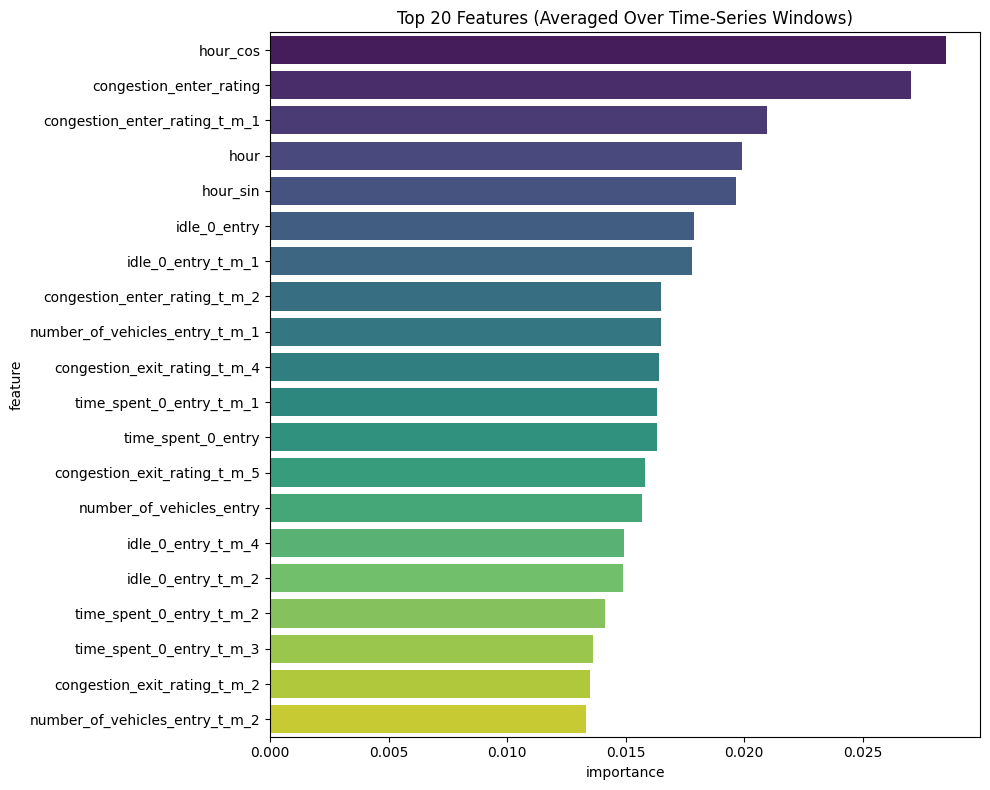

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, f1_score

# 1. Setup & Configuration
# NOTE: Ensure your DataFrame (X and y_enter) is sorted by your time/index before this!
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits) # Switched from StratifiedKFold to TimeSeriesSplit
target_cols = y_enter.columns.tolist()

# Prepare directory for outputs
model_dir = 'traffic_timeseries_analysis'
os.makedirs(model_dir, exist_ok=True)

# Data containers
fold_results = []
all_importances = []

# Calculate weights based on the distribution of the primary target
weights = compute_sample_weight(class_weight='balanced', y=y_enter[target_cols[0]])

print(f"\n{'='*75}")
print(f"XGBoost TIME-SERIES Training: {n_splits} Windows x {len(target_cols)} Time Steps")
print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
print(f"{'='*75}\n")

# 2. Training Loop
fold_num = 0
# TimeSeriesSplit works by creating expanding training windows
for train_idx, val_idx in tscv.split(X):
    fold_num += 1

    # Slice features and targets using position-based indexing
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_df, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]

    # Slice weights to match only the current training window
    train_weights = weights[train_idx]

    all_target_preds = []

    # Create sub-directory for this specific fold
    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    for col in target_cols:
        # Initialize model with conservative parameters to prevent overfitting
        model = XGBClassifier(
            n_estimators=2000,
            learning_rate=0.01,
            max_depth=6,
            early_stopping_rounds=50,
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            tree_method='hist',
            subsample=0.8,
            colsample_bytree=0.8,
            max_delta_step=2 # Useful for imbalanced multi-class
        )

        # Fit with Early Stopping using the validation window
        model.fit(
            X_train, y_train_df[col],
            sample_weight=train_weights,
            eval_set=[(X_val, y_val_df[col])], # Monitoring future data window
            verbose=False
        )

        # A. Capture Feature Importance
        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_importances.append(imp_df)

        # B. Save model as JSON
        model.save_model(os.path.join(fold_path, f'model_{col}.json'))

        # C. Predict classes
        all_target_preds.append(model.predict(X_val))

    # 3. Evaluation (Flattening across the 5-minute prediction horizon)
    y_pred_final = np.column_stack(all_target_preds)
    y_val_flat = y_val_df.to_numpy().flatten()
    y_pred_flat = y_pred_final.flatten()

    fold_acc = accuracy_score(y_val_flat, y_pred_flat)
    fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

    fold_results.append({
        "fold": fold_num,
        "accuracy": fold_acc,
        "f1_macro": fold_f1_macro
    })

    print(f"Window {fold_num:02d}: Accuracy={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# --- 4. Final Aggregation ---

total_importance_df = pd.concat(all_importances)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()
global_importance.to_csv(os.path.join(model_dir, 'global_importance.csv'), index=False)

fold_df = pd.DataFrame(fold_results)
fold_df.to_csv(os.path.join(model_dir, 'cv_metrics.csv'), index=False)

# Final Print Summary
print(f"\n{'-'*75}")
print(f"TIME-SERIES CROSS-VALIDATION RESULTS")
print(f"Mean Accuracy: {fold_df['accuracy'].mean():.4f}")
print(f"Mean F1-Macro: {fold_df['f1_macro'].mean():.4f}")
print(f"{'-'*75}\n")

# Top 20 Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Features (Averaged Over Time-Series Windows)')
plt.tight_layout()
plt.show()

# OG


XGBoost Multi-Target Training: 10 Folds x 5 Time Steps (50 Models Total)
Features: 84 | Samples: 1178

Fold 01: Global Acc=0.6102 | F1-Macro=0.4097
Fold 02: Global Acc=0.6136 | F1-Macro=0.4420
Fold 03: Global Acc=0.6000 | F1-Macro=0.4097
Fold 04: Global Acc=0.6169 | F1-Macro=0.4579
Fold 05: Global Acc=0.5492 | F1-Macro=0.3936
Fold 06: Global Acc=0.5492 | F1-Macro=0.3717
Fold 07: Global Acc=0.5831 | F1-Macro=0.4075
Fold 08: Global Acc=0.5847 | F1-Macro=0.4314
Fold 09: Global Acc=0.5966 | F1-Macro=0.4194
Fold 10: Global Acc=0.6051 | F1-Macro=0.4363

---------------------------------------------------------------------------
FINAL RESULTS
Average Accuracy: 0.5908 (+/- 0.0246)
Average F1-Macro: 0.4179
---------------------------------------------------------------------------



/tmp/ipython-input-3771062026.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='magma')


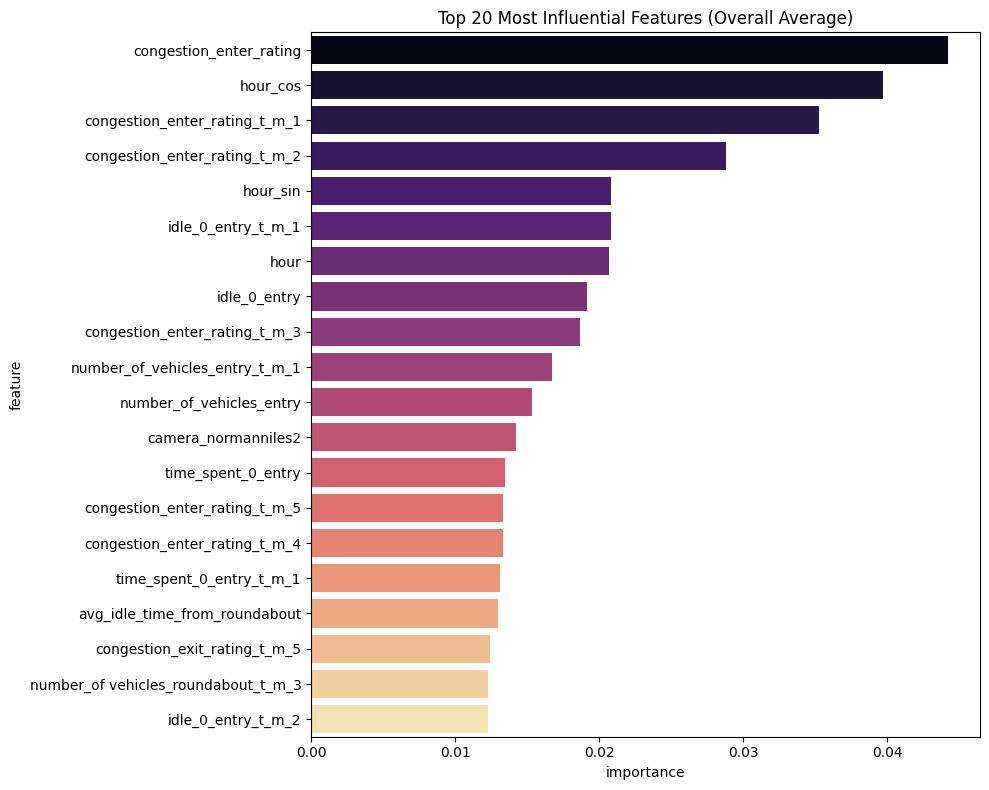

Training Complete. All models and analysis saved to folder: 'traffic_analysis_results_01'


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, f1_score

# 1. Setup & Configuration
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
target_cols = y_enter.columns.tolist()

# Prepare directory for outputs
model_dir = 'traffic_analysis_results_01'
os.makedirs(model_dir, exist_ok=True)

# Data containers
fold_results = []
all_importances = []
weights = compute_sample_weight(class_weight='balanced', y=y_enter[target_cols[0]])

print(f"\n{'='*75}")
print(f"XGBoost Multi-Target Training: 10 Folds x 5 Time Steps (50 Models Total)")
print(f"Features: {X.shape[1]} | Samples: {X.shape[0]}")
print(f"{'='*75}\n")

# 2. Training Loop
fold_num = 0
for train_idx, val_idx in skf.split(X, y_enter[target_cols[0]]):
    fold_num += 1

    # Slice features and targets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_df, y_val_df = y_enter.iloc[train_idx], y_enter.iloc[val_idx]
    train_weights = weights[train_idx]

    all_target_preds = []

    # Create sub-directory for this specific fold
    fold_path = os.path.join(model_dir, f'fold_{fold_num}')
    os.makedirs(fold_path, exist_ok=True)

    for col in target_cols:
        # Initialize model for this specific minute
        model = XGBClassifier(
            n_estimators=2000,
            learning_rate=0.01,
            max_depth=3,
            early_stopping_rounds=50,
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            tree_method='hist',
            subsample=0.8,
            colsample_bytree=0.8,
            max_delta_step=1
        )

        # Fit with Early Stopping and Weights
        model.fit(
            X_train, y_train_df[col],
            sample_weight=train_weights,
            eval_set=[(X_val, y_val_df[col])],
            verbose=False
        )

        # A. Capture Feature Importance for this specific target
        imp_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'target': col,
            'fold': fold_num
        })
        all_importances.append(imp_df)

        # B. Save the model
        model.save_model(os.path.join(fold_path, f'model_{col}.json'))

        # C. Predict for evaluation
        all_target_preds.append(model.predict(X_val))

    # 3. Fold Evaluation
    y_pred_final = np.column_stack(all_target_preds)

    # Flatten across all 5 minutes to get a total performance score
    y_val_flat = y_val_df.to_numpy().flatten()
    y_pred_flat = y_pred_final.flatten()

    fold_acc = accuracy_score(y_val_flat, y_pred_flat)
    fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

    fold_results.append({
        "fold": fold_num,
        "accuracy": fold_acc,
        "f1_macro": fold_f1_macro
    })

    print(f"Fold {fold_num:02d}: Global Acc={fold_acc:.4f} | F1-Macro={fold_f1_macro:.4f}")

# --- 4. Post-Training Analysis ---

# Process Feature Importance
total_importance_df = pd.concat(all_importances)

# Calculate global importance (average across all folds and all time-steps)
global_importance = total_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()
global_importance.to_csv(os.path.join(model_dir, 'global_feature_importance.csv'), index=False)

# Calculate importance per target (t_1, t_2... etc)
target_importance = total_importance_df.groupby(['target', 'feature'])['importance'].mean().reset_index()
target_importance.to_csv(os.path.join(model_dir, 'importance_by_time_step.csv'), index=False)

# 5. Final Metrics and Metadata
fold_df = pd.DataFrame(fold_results)
fold_df.to_csv(os.path.join(model_dir, 'cv_metrics.csv'), index=False)

metadata = {
    'timestamp': datetime.now().isoformat(),
    'n_folds': n_splits,
    'mean_accuracy': float(fold_df['accuracy'].mean()),
    'std_accuracy': float(fold_df['accuracy'].std()),
    'mean_f1_macro': float(fold_df['f1_macro'].mean()),
    'top_5_features': global_importance['feature'].head(5).tolist(),
    'model_config': {
        'model_type': 'XGBoostClassifier',
        'n_estimators': 2000,
        'learning_rate': 0.01,
        'max_depth': 3,
        'early_stopping_rounds': 50,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'tree_method': 'hist',
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'max_delta_step': 1
    },
}

with open(os.path.join(model_dir, 'summary_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

# 6. Final Report Visualization
print(f"\n{'-'*75}")
print(f"FINAL RESULTS")
print(f"Average Accuracy: {metadata['mean_accuracy']:.4f} (+/- {metadata['std_accuracy']:.4f})")
print(f"Average F1-Macro: {metadata['mean_f1_macro']:.4f}")
print(f"{'-'*75}\n")

# Visualize Top 20 Features
plt.figure(figsize=(10, 8))
sns.barplot(data=global_importance.head(20), x='importance', y='feature', palette='magma')
plt.title('Top 20 Most Influential Features (Overall Average)')
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'top_features_plot.png'))
plt.show()

print(f"Training Complete. All models and analysis saved to folder: '{model_dir}'")

In [ ]:
!zip -r traffic_analysis_results_01.zip traffic_analysis_results_01

  adding: traffic_analysis_results_01/ (stored 0%)
  adding: traffic_analysis_results_01/fold_5/ (stored 0%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_3.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_5.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_1.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_2.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_5/model_congestion_enter_rating_t_4.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_4/ (stored 0%)
  adding: traffic_analysis_results_01/fold_4/model_congestion_enter_rating_t_3.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_4/model_congestion_enter_rating_t_5.json (deflated 79%)
  adding: traffic_analysis_results_01/fold_4/model_congestion_enter_rating_t_1.json (deflated 79%)
  adding: traffic_analysis_results_01/fol

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.multioutput import MultiOutputClassifier
# from xgboost import XGBClassifier
# from sklearn.utils.class_weight import compute_sample_weight
# import os
# import json

# n_splits = 10
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# lst_accu_stratified = []

# weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_enter['congestion_enter_rating_t_1']
# )

# # base_classifier = XGBClassifier(
# #     n_estimators=100,
# #     early_stopping_rounds=500,
# #     learning_rate=0.05,
# #     max_depth=4,
# #     objective='multi:softprob',
# #     eval_metric='mlogloss',
# #     tree_method='hist',
# #     random_state=42
# # )

# # model = MultiOutputClassifier(base_classifier)

# fold_results = []
# feature_importance_list = []
# models_list = []

# print(f"\n{'='*70}")
# print(f"Training: XGBoostClassifier")
# print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}, Classes: {len(np.unique(y_enter))}")
# print(f"{'='*70}\n")

# target_cols = y_enter.columns.tolist()

# fold_num = 0
# for train_idx, val_idx in skf.split(X, y_enter['congestion_enter_rating_t_1']):
#   fold_num += 1

#   X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#   y_train, y_val = y_enter.iloc[train_idx], y_enter.iloc[val_idx]
#   train_weights = weights[train_idx]

#   all_target_preds = []

#   for col in target_cols:
#     model = XGBClassifier(
#         n_estimators=1000,
#         learning_rate=0.05,
#         max_depth=4,
#         early_stopping_rounds=50,
#         objective='multi:softprob',
#         eval_metric='mlogloss',
#         random_state=42
#     )

#     # Fit model for this specific time step
#     model.fit(
#         X_train, y_train[col],
#         sample_weight=train_weights,
#         eval_set=[(X_val, y_val[col])], # Validating against the specific time step
#         verbose=False
#     )

#     y_pred_single_col = model.predict(X_val)
#     all_target_preds.append(y_pred_single_col)

#   y_pred_final = np.column_stack(all_target_preds)

#   y_val_flat = y_val.to_numpy().flatten()
#   y_pred_flat = y_pred_final.flatten()

#   fold_acc = accuracy_score(y_val_flat, y_pred_flat)
#   fold_f1_macro = f1_score(y_val_flat, y_pred_flat, average="macro", zero_division=0)

#   fold_results.append({
#       "fold": fold_num,
#       "accuracy": fold_acc,
#       "f1_macro": fold_f1_macro
#   })

#   feature_importance_list.append(model.feature_importances_)
#   models_list.append(model)

#   print(f"Fold {fold_num} : Accuracy={fold_acc:.4f}, F1-Macro={fold_f1_macro:.4f}")

# fold_df = pd.DataFrame(fold_results)

# print(f"\n{'-'*70}")
# print(f"Mean Accuracy: {fold_df['accuracy'].mean():.4f} (+/- {fold_df['accuracy'].std():.4f})")
# print(f"Mean F1-Macro: {fold_df['f1_macro'].mean():.4f} (+/- {fold_df['f1_macro'].std():.4f})")
# print(f"{'-'*70}\n")

# model_dir = 'models'
# os.makedirs(model_dir, exist_ok=True)

# for fold_idx, fold_model in enumerate(models_list, 1):
#   model_path = os.path.join(model_dir, f'model_fold_{fold_idx}.txt')
#   fold_model.save_model(model_path)
# results_path = os.path.join(model_dir, 'results.csv')
# fold_df.to_csv(results_path, index=False)

# metadata = {
#     'model_name': 'XGBoostClassifier',
#     'timestamp': datetime.now().isoformat(),
#     'n_folds': n_splits,
#     'mean_accuracy': float(fold_df['accuracy'].mean()),
#     'std_accuracy': float(fold_df['accuracy'].std()),
#     'mean_f1_macro': float(fold_df['f1_macro'].mean()),
#     'std_f1_macro': float(fold_df['f1_macro'].std()),
#     'feature_count': len(X.columns)
# }
# metadata_path = os.path.join(model_dir, 'metadata.json')
# with open(metadata_path, 'w') as f:
#   json.dump(metadata, f, indent=4)


Training: XGBoostClassifier
Samples: 1178, Features: 84, Classes: 4



XGBoostError: [17:30:03] /workspace/include/xgboost/objective.h:107: multioutput is not supported by the current objective function
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x2be09c) [0x7da5aa8be09c]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x6ef1d2) [0x7da5aacef1d2]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterBoostedRounds+0x34) [0x7da5aa7c83d4]
  [bt] (3) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7da5f1c56e2e]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7da5f1c53493]
  [bt] (5) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7da5f2fd68c1]
  [bt] (6) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x8ffe) [0x7da5f2fd5ffe]
  [bt] (7) /usr/bin/python3(_PyObject_MakeTpCall+0x2fb) [0x53f5db]
  [bt] (8) /usr/bin/python3(_PyEval_EvalFrameDefault+0x701) [0x54a2e1]

